<a href="https://colab.research.google.com/github/rromerov/Proyecto_Integrador/blob/main/Avance5/Avance5.12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instituto Tecnológico y de Estudios Superiores de Monterrey
## Maestría en Inteligencia Artificial Aplicada
### Proyecto Integrador (Gpo 10) - TC5035.10

### **Proyecto: Aplicación de Modelos de Machine Learning y Acoplamiento Molecular en el Diseño Acelerado de Fármacos, propuesta contra la Viruela del Simio (MPOX). Enfoque en la Proteína F13; con Datos Experimentales Limitados.**

### Avance 5: Modelo Final

#### **Docentes:**
- Dra. Grettel Barceló Alonso - Profesor Titular
- Dr. Luis Eduardo Falcón Morales - Profesor Titular
- Dr. Carlos Alberto Brizuela Rodríguez  – Profesor Tutor

#### **Miembro del equipo:**
- Carlos Mario Larrahondo Valencia - A01794031



---


### Modelo Final




---

### Modelos de ensamble




---





---

### Código para el modelo

Se importan las librerías necesarias y se instalan los paquetes de Python

In [1]:
%%capture
# Instalar librerias
! pip install datasets
! pip install transformers[torch]
! pip install accelerate -U
! pip install rdkit
! pip install rdkit-pypi
! pip install scikit-optimize

# Librería para búsqueda de nombre de moléculas
! pip install chembl_webresource_client

In [2]:
# Importar librerías necesarias

# Librerías básicas
import pandas as pd
import numpy as np
from random import sample
import re
import sys
import os
import warnings
import time

# Librerías SKLearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

from sklearn.exceptions import ConvergenceWarning

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

from sklearn.tree import plot_tree
from sklearn.inspection import permutation_importance

from sklearn.preprocessing import MinMaxScaler

# Libreria para procesamiento paralelo
import joblib
from joblib import Parallel, delayed, parallel_backend, parallel_config

# Libreria para desplegar numero de CPUs Colab
import multiprocessing as mp

# SK Librerías optimización
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize

# Librerías para graficar
import seaborn as sns
import matplotlib.pyplot as plt

# Librerías modelo para modelo MLM
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments, RobertaForCausalLM, pipeline
from datasets import Dataset
import torch

# Librerías para trabajar con canonical smiles
from rdkit.Chem import rdchem
from rdkit import Chem
from rdkit.Chem import Draw
from PIL import Image
import difflib

# Librerías Colab
from google.colab import data_table, drive

# Chembl Client
from chembl_webresource_client.new_client import new_client

# **Optimización de hiperparámetros para los modelos más relevantes**

Cargamos los datos generados en fases anteriores

In [3]:
# Configurar el método de inicio a 'spawn'
mp.set_start_method('spawn', force=True)

# Verificar el método configurado
print(f"Method start: {mp.get_start_method()}")

Method start: spawn


In [4]:
# Verificar el número de CPUs disponibles
num_cpus = mp.cpu_count()
print(f"Number of CPUs available: {num_cpus}")

Number of CPUs available: 2


In [5]:
# Configurar el backend globalmente
parallel_config(backend='loky')

# Cargar Google Drive al notebook
drive.mount('/content/drive')

# Cargar el dataset
ruta_archivo_bioactivity = '/content/drive/My Drive/Colab Notebooks/data/bioactivity_data_2class_pIC50_pubchem_fp.csv'

# Lee el archivo CSV en un DataFrame
df_bioactivity = pd.read_csv(ruta_archivo_bioactivity)

# Mostrar que se haya importado correctamente el archivo
df_bioactivity.head(5)

Mounted at /content/drive


,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.390983
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.267701
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.365195
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.600735
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.483040


In [6]:
# Se define conjunto X para las etiquetas
X = df_bioactivity.drop('pIC50', axis=1)
# Mostrar contenido en el conjunto de X
X

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
208,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
209,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
210,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Se define variable Y para el objetivo
Y = df_bioactivity.pIC50
# Mostrar contenido en el conjunto de Y
Y

,pIC50
0,0.390983
1,0.267701
2,0.365195
3,0.600735
4,0.483040
...,...
207,0.917519
208,0.621666
209,0.275419
210,0.640614


#### Dimensión de los conjuntos



In [8]:
# Dimensiones de las variables predictoras
X.shape

(212, 881)

In [9]:
# Dimensiones de la variable predicha
Y.shape

(212,)

#### Data split

Generamos conjuntos de entrenamiento y prueba

(80/20 ratio)

In [11]:
# Dividimos los datos en dos conjuntos, los de entrenamiento y los de prueba, teniendo los últimos un 20% de las muestras
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
# Dimensiones del conjunto de entrenamiento
X_train.shape, Y_train.shape

((169, 881), (169,))

In [12]:
# Dimensiones del conjunto de prueba
X_test.shape, Y_test.shape

((43, 881), (43,))

#### Comparación de rendimiento de modelos


# **Ensamble Homogéneas**

In [13]:
# Suprimir warnings
warnings.filterwarnings("ignore", category=UserWarning, module='skopt.optimizer.optimizer')
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [14]:
# Definir una función para evaluar el rendimiento del modelo con métricas adicionales
def evaluate_model(model, X_test, Y_test):
    Y_pred = model.predict(X_test)
    metrics = {
        'R^2': r2_score(Y_test, Y_pred),
        'MAE': mean_absolute_error(Y_test, Y_pred),
        'MSE': mean_squared_error(Y_test, Y_pred),
        'RMSE': np.sqrt(mean_squared_error(Y_test, Y_pred)),
        'MAPE': mean_absolute_percentage_error(Y_test, Y_pred),
        'Explained Variance': explained_variance_score(Y_test, Y_pred),
        'Max Error': max_error(Y_test, Y_pred),
        'Median AE': median_absolute_error(Y_test, Y_pred)
    }
    return metrics

In [15]:
# Definir una función para optimizar los hiperparámetros
def optimize_hyperparameters(model_type, space, n_calls=10, random_state=42):
    @use_named_args(space)
    def objective_function(**params):
        if model_type == 'RandomForest':
            model = RandomForestRegressor(**params, random_state=random_state, n_jobs=-1)
        elif model_type == 'SVR':
            model = SVR(**params)
        elif model_type == 'KNeighbors':
            model = KNeighborsRegressor(**params, n_jobs=-1)
        else:
            raise ValueError(f"Modelo no válido: {model_type}")

        # Usar validación cruzada para evaluar el modelo con múltiples núcleos
        score = cross_val_score(model, X_train, Y_train, cv=3, n_jobs=-1, scoring='r2').mean()
        return -score  # Minimizar el negativo de R²

    result = gp_minimize(objective_function, space, n_calls=n_calls, random_state=random_state)
    return result

In [16]:
# Imprimir los resultados
def print_metrics(model_name, metrics):
    df_metrics = pd.DataFrame(metrics, index=[model_name])
    print(df_metrics)

In [17]:
# Ajustar los espacios de búsqueda para cada modelo
rf_space = [
    Integer(170, 190, name='n_estimators'),
    Integer(12, 16, name='max_depth'),
]

svr_space = [
    Real(1e1, 1e3, name='C'),
    Real(1e-2, 1e2, name='gamma')
]

knn_space = [
    Integer(2, 6, name='n_neighbors'),
    Integer(1, 2, name='p'),  # 1 para Manhattan, 2 para Euclidean
]

In [18]:
X_train.shape

(169, 881)

In [19]:
with parallel_backend('loky'):
  rf_result = optimize_hyperparameters('RandomForest', rf_space)
  rf_best_params = dict(zip([dim.name for dim in rf_space], rf_result.x))
  rf_model = RandomForestRegressor(**rf_best_params, random_state=42)
  rf_model.fit(X_train, Y_train)
  rf_metrics = evaluate_model(rf_model, X_test, Y_test)

In [20]:
svr_result = optimize_hyperparameters('SVR', svr_space)
svr_best_params = dict(zip([dim.name for dim in svr_space], svr_result.x))
svr_model = SVR(**svr_best_params)
svr_model.fit(X_train, Y_train)
svr_metrics = evaluate_model(svr_model, X_test, Y_test)

In [21]:
with parallel_backend('loky'):
  knn_result = optimize_hyperparameters('KNeighbors', knn_space)
  knn_best_params = dict(zip([dim.name for dim in knn_space], knn_result.x))
  knn_model = KNeighborsRegressor(**knn_best_params)
  knn_model.fit(X_train, Y_train)
  knn_metrics = evaluate_model(knn_model, X_test, Y_test)

In [22]:
# Mostrar mejores hiperparámetros para cada modelo
print("Random Forest Best Parameters:", rf_best_params)
print("SVR Best Parameters:", svr_best_params)
print("KNeighbors Best Parameters:", knn_best_params)

Random Forest Best Parameters: {'n_estimators': 186, 'max_depth': 14}
SVR Best Parameters: {'C': 939.1671819255929, 'gamma': 0.0878687964430227}
KNeighbors Best Parameters: {'n_neighbors': 2, 'p': 2}


In [23]:
# Imprimir métricas para cada modelo
rf_metrics

{'R^2': 0.5561891463547607,
 'MAE': 0.12491196962580471,
 'MSE': 0.02525954153982576,
 'RMSE': 0.1589325062403087,
 'MAPE': 0.8432663150028783,
 'Explained Variance': 0.5583171562282591,
 'Max Error': 0.37640957287361837,
 'Median AE': 0.09873019720254428}

In [24]:
# Imprimir métricas para cada modelo
svr_metrics

{'R^2': 0.4137753924669699,
 'MAE': 0.1478133557899389,
 'MSE': 0.03336503536140473,
 'RMSE': 0.182660984781657,
 'MAPE': 0.9546692657529656,
 'Explained Variance': 0.4146362761872192,
 'Max Error': 0.5043483886083131,
 'Median AE': 0.11411135359782787}

In [25]:
# Imprimir métricas para cada modelo
knn_metrics

{'R^2': 0.6033229985372888,
 'MAE': 0.11999633371897978,
 'MSE': 0.022576913372087743,
 'RMSE': 0.15025615918187096,
 'MAPE': 0.7994383656390367,
 'Explained Variance': 0.6220442185314268,
 'Max Error': 0.33009292322852346,
 'Median AE': 0.10706709312107765}

In [26]:
# Graficar la curva de aprendizaje
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=3, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    # Obtener las curvas de aprendizaje
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, random_state=42)

    # Calcular medias y desviaciones estándar
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    # Área de la desviación estándar
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")

    # Curvas de media
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

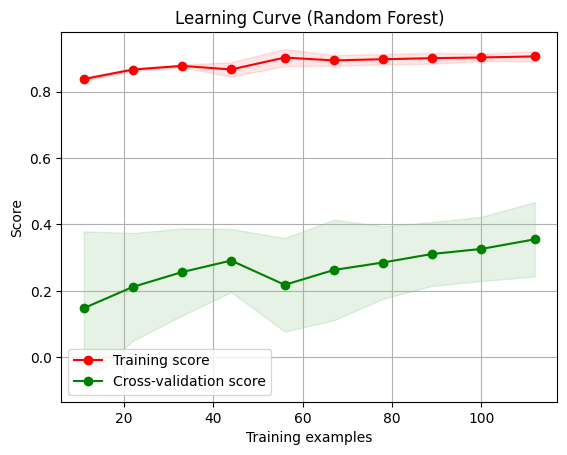

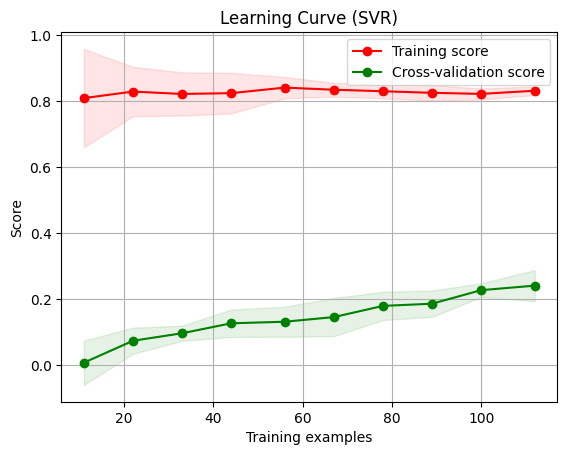

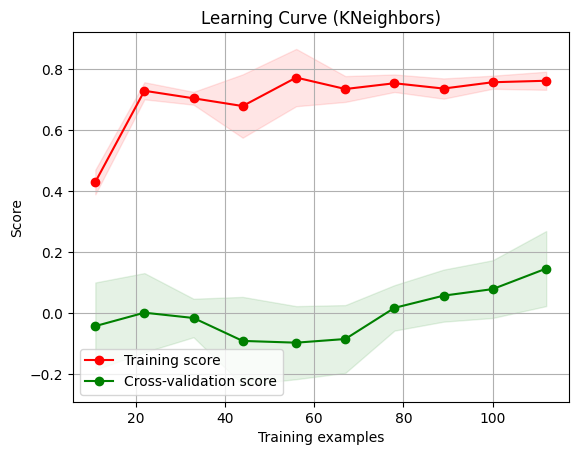

In [27]:
with parallel_backend('loky'):
  # Graficar la curva de aprendizaje para cada modelo
  plot_learning_curve(rf_model, "Learning Curve (Random Forest)", X_train, Y_train, cv=3)
  plt.show()

  plot_learning_curve(svr_model, "Learning Curve (SVR)", X_train, Y_train, cv=3)
  plt.show()

  plot_learning_curve(knn_model, "Learning Curve (KNeighbors)", X_train, Y_train, cv=3)
  plt.show()

In [28]:
# Función para calcular y mostrar las métricas
def print_metrics(y_true, y_pred, model_name, training_time):
    metrics = {
        'training_time': training_time,
        'R_squ': r2_score(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred),
        'Explained Variance': explained_variance_score(y_true, y_pred),
        'Max Error': max_error(y_true, y_pred),
        'Median AE': median_absolute_error(y_true, y_pred)
    }
    print(f"Metrics for {model_name}:")
    print("Training Time:", training_time, "seconds")
    print("Mean Absolute Error (MAE):", metrics['MAE'])
    print("Mean Squared Error (MSE):", metrics['MSE'])
    print("Root Mean Squared Error (RMSE):", metrics['RMSE'])
    print("Mean Absolute Percentage Error (MAPE):", metrics['MAPE'])
    print("Explained Variance Score:", metrics['Explained Variance'])
    print("Max Error:", metrics['Max Error'])
    print("Median Absolute Error:", metrics['Median AE'])
    print("R^2 Score:", metrics['R_squ'])
    return metrics

# **Ensamble Homogéneas**

In [29]:
# Ensamble Homogéneo con Random Forest
rf_model = RandomForestRegressor(n_estimators=rf_best_params['n_estimators'],
                                           max_depth=rf_best_params['max_depth'])

In [30]:
start_time = time.time()
rf_model.fit(X_train, Y_train)
end_time = time.time()
rf_training_time = end_time - start_time
rf_pred = rf_model.predict(X_test)
rf_metrics = print_metrics(Y_test, rf_pred, "Random Forest Regressor", rf_training_time)

Metrics for Random Forest Regressor:
Training Time: 2.3518073558807373 seconds
Mean Absolute Error (MAE): 0.12341399478994405
Mean Squared Error (MSE): 0.025831771364612267
Root Mean Squared Error (RMSE): 0.16072265355142773
Mean Absolute Percentage Error (MAPE): 0.8459574558135189
Explained Variance Score: 0.5496783307084228
Max Error: 0.38655590485620683
Median Absolute Error: 0.09374231475960065
R^2 Score: 0.5461350522763171


In [31]:
# Ensamble Homogéneo con SVR
svr = SVR(C=svr_best_params['C'],
                          gamma=svr_best_params['gamma'])

In [32]:
start_time = time.time()
svr.fit(X_train, Y_train)
end_time = time.time()
svr_training_time = end_time - start_time
svr_pred = svr.predict(X_test)
svr_metrics = print_metrics(Y_test, rf_pred, "SVR Regressor", svr_training_time)

Metrics for SVR Regressor:
Training Time: 0.0148468017578125 seconds
Mean Absolute Error (MAE): 0.12341399478994405
Mean Squared Error (MSE): 0.025831771364612267
Root Mean Squared Error (RMSE): 0.16072265355142773
Mean Absolute Percentage Error (MAPE): 0.8459574558135189
Explained Variance Score: 0.5496783307084228
Max Error: 0.38655590485620683
Median Absolute Error: 0.09374231475960065
R^2 Score: 0.5461350522763171


In [33]:
# Ensamble Homogéneo con KNN
knn = KNeighborsRegressor(n_neighbors=knn_best_params['n_neighbors'],
                                          p=knn_best_params['p'])

In [34]:
start_time = time.time()
knn.fit(X_train, Y_train)
end_time = time.time()
knn_training_time = end_time - start_time
knn_pred = knn_model.predict(X_test)
knn_metrics = print_metrics(Y_test, rf_pred, "KNN Regressor", knn_training_time)

Metrics for KNN Regressor:
Training Time: 0.0070934295654296875 seconds
Mean Absolute Error (MAE): 0.12341399478994405
Mean Squared Error (MSE): 0.025831771364612267
Root Mean Squared Error (RMSE): 0.16072265355142773
Mean Absolute Percentage Error (MAPE): 0.8459574558135189
Explained Variance Score: 0.5496783307084228
Max Error: 0.38655590485620683
Median Absolute Error: 0.09374231475960065
R^2 Score: 0.5461350522763171


# **Ensamble Heterogéneas**

In [35]:
# Ensamble Heterogéneo con Voting
voting_model = VotingRegressor(estimators=[('rf', rf_model), ('svr', svr), ('knn', knn)])
start_time = time.time()
voting_model.fit(X_train, Y_train)
end_time = time.time()
voting_training_time = end_time - start_time
voting_pred = voting_model.predict(X_test)
voting_metrics = print_metrics(Y_test, voting_pred, "Voting Regressor", voting_training_time)

Metrics for Voting Regressor:
Training Time: 1.0958142280578613 seconds
Mean Absolute Error (MAE): 0.11751226099083883
Mean Squared Error (MSE): 0.022959715264698036
Root Mean Squared Error (RMSE): 0.15152463583423667
Mean Absolute Percentage Error (MAPE): 0.8306514725340861
Explained Variance Score: 0.5996524151981213
Max Error: 0.3433356802855792
Median Absolute Error: 0.08912641729871243
R^2 Score: 0.5965971585425871


In [36]:
X_train.shape

(169, 881)

In [37]:
# Ensamble Heterogéneo con Stacking
estimators = [
    ('rf', rf_model),
    ('svr', svr),
    ('knn', knn)
]
meta_model = LinearRegression()
stacking_model = StackingRegressor(estimators=estimators, final_estimator=meta_model)
stacking_model.fit(X_train, Y_train)
start_time = time.time()
stacking_pred = stacking_model.predict(X_test)
end_time = time.time()
stacking_training_time = end_time - start_time
stacking_metrics = print_metrics(Y_test, stacking_pred, "Stacking Regressor", stacking_training_time)

Metrics for Stacking Regressor:
Training Time: 0.04113507270812988 seconds
Mean Absolute Error (MAE): 0.11876615863168288
Mean Squared Error (MSE): 0.022632609197300715
Root Mean Squared Error (RMSE): 0.1504413812662617
Mean Absolute Percentage Error (MAPE): 0.8043783241914637
Explained Variance Score: 0.6026088848742325
Max Error: 0.3455784579801197
Median Absolute Error: 0.09912381552719712
R^2 Score: 0.6023444213254548


In [38]:
# Estrategia de Blending
def blending_predict(X_train, y_train, X_test, start_time):
    # Dividir el conjunto de entrenamiento en entrenamiento y validación
    X_train_blend, X_val_blend, y_train_blend, y_val_blend = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Ajustar los modelos base en el conjunto de entrenamiento
    rf_model_blend = RandomForestRegressor(n_estimators=rf_best_params['n_estimators'],
                                           max_depth=rf_best_params['max_depth'],
                                           random_state=42)
    svr_model_blend = SVR(C=svr_best_params['C'],
                          gamma=svr_best_params['gamma'])
    knn_model_blend = KNeighborsRegressor(n_neighbors=knn_best_params['n_neighbors'],
                                          p=knn_best_params['p'])

    rf_model_blend.fit(X_train_blend, y_train_blend)
    svr_model_blend.fit(X_train_blend, y_train_blend)
    knn_model_blend.fit(X_train_blend, y_train_blend)

    # Predecir en el conjunto de validación
    rf_pred = rf_model_blend.predict(X_val_blend)
    svr_pred = svr_model_blend.predict(X_val_blend)
    knn_pred = knn_model_blend.predict(X_val_blend)

    # Crear el conjunto de datos para el meta-modelo
    meta_features = np.column_stack((rf_pred, svr_pred, knn_pred))

    # Ajustar el meta-modelo
    meta_model_blend = LinearRegression()
    meta_model_blend.fit(meta_features, y_val_blend)

    # Predecir en el conjunto de prueba
    rf_test_pred = rf_model_blend.predict(X_test)
    svr_test_pred = svr_model_blend.predict(X_test)
    knn_test_pred = knn_model_blend.predict(X_test)

    # Crear el conjunto de datos para el meta-modelo con las predicciones del conjunto de prueba
    meta_test_features = np.column_stack((rf_test_pred, svr_test_pred, knn_test_pred))

    # Predecir con el meta-modelo
    final_predictions = meta_model_blend.predict(meta_test_features)

    return final_predictions, time.time() - start_time

In [39]:
# Obtener las predicciones del modelo blending
start_time = time.time()
blending_predictions, blending_training_time = blending_predict(X_train, Y_train, X_test, start_time)
blending_metrics = print_metrics(Y_test, blending_predictions, "Blending Model", blending_training_time)

Metrics for Blending Model:
Training Time: 0.994511604309082 seconds
Mean Absolute Error (MAE): 0.1380555420852283
Mean Squared Error (MSE): 0.03009646127453704
Root Mean Squared Error (RMSE): 0.173483316991972
Mean Absolute Percentage Error (MAPE): 0.8151057650187731
Explained Variance Score: 0.4798682039099823
Max Error: 0.3759151310136845
Median Absolute Error: 0.1011581853596965
R^2 Score: 0.4712043308904288


# **Tablas comparativas**

In [40]:
# Lista de diccionarios con el nombre del modelo
metrics_list = [
    {'Model': 'Random Forest', **rf_metrics},
    {'Model': 'SVR', **svr_metrics},
    {'Model': 'KNN', **knn_metrics},
    {'Model': 'Voting Regressor', **voting_metrics},
    {'Model': 'Stacking Regressor', **stacking_metrics},
    {'Model': 'Blending Model', **blending_metrics}
]

In [41]:
# Crear el DataFrame
metrics_df = pd.DataFrame(metrics_list)

# Mostrar la tabla en Colab
data_table.DataTable(metrics_df, include_index=False)

,Model,training_time,R_squ,MAE,MSE,RMSE,MAPE,Explained Variance,Max Error,Median AE
0,Random Forest,2.351807,0.546135,0.123414,0.025832,0.160723,0.845957,0.549678,0.386556,0.093742
1,SVR,0.014847,0.546135,0.123414,0.025832,0.160723,0.845957,0.549678,0.386556,0.093742
2,KNN,0.007093,0.546135,0.123414,0.025832,0.160723,0.845957,0.549678,0.386556,0.093742
3,Voting Regressor,1.095814,0.596597,0.117512,0.022960,0.151525,0.830651,0.599652,0.343336,0.089126
4,Stacking Regressor,0.041135,0.602344,0.118766,0.022633,0.150441,0.804378,0.602609,0.345578,0.099124
5,Blending Model,0.994512,0.471204,0.138056,0.030096,0.173483,0.815106,0.479868,0.375915,0.101158


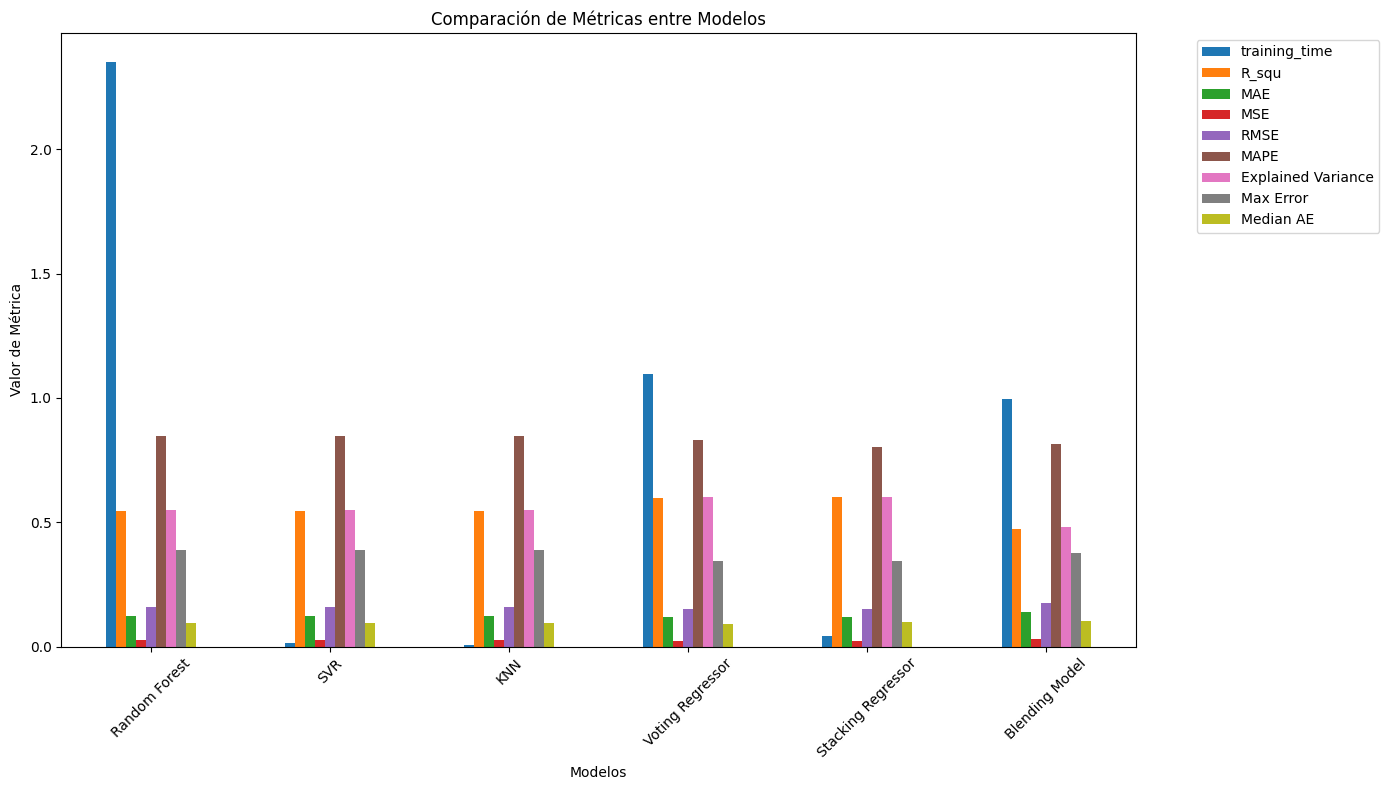

In [42]:
# Crear un gráfico de barras agrupadas
metrics_df.set_index('Model', inplace=True)
metrics_df.plot(kind='bar', figsize=(14, 8))
plt.title('Comparación de Métricas entre Modelos')
plt.ylabel('Valor de Métrica')
plt.xlabel('Modelos')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [43]:
# Entrenar nuevamente el modelo Stacking Regressor para obtener predicciones y residuos
estimators = [
    ('rf', rf_model),
    ('svr', svr),
    ('knn', knn)
]
meta_model = LinearRegression()
stacking_model = StackingRegressor(estimators=estimators, final_estimator=meta_model)
stacking_model.fit(X_train, Y_train)
stacking_pred = stacking_model.predict(X_test)
residuals = Y_test - stacking_pred

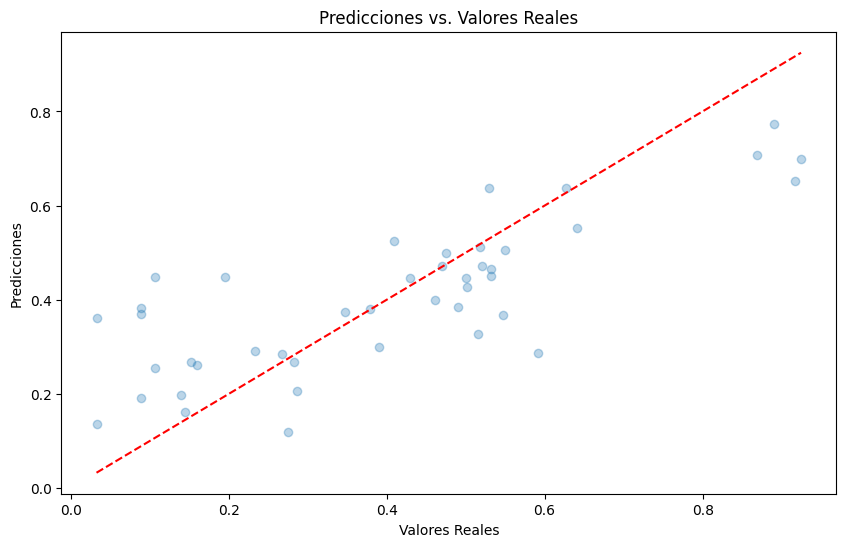

In [44]:
# 1. Predicciones vs. Valores Reales
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, stacking_pred, alpha=0.3)
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linestyle='--')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs. Valores Reales')
plt.show()

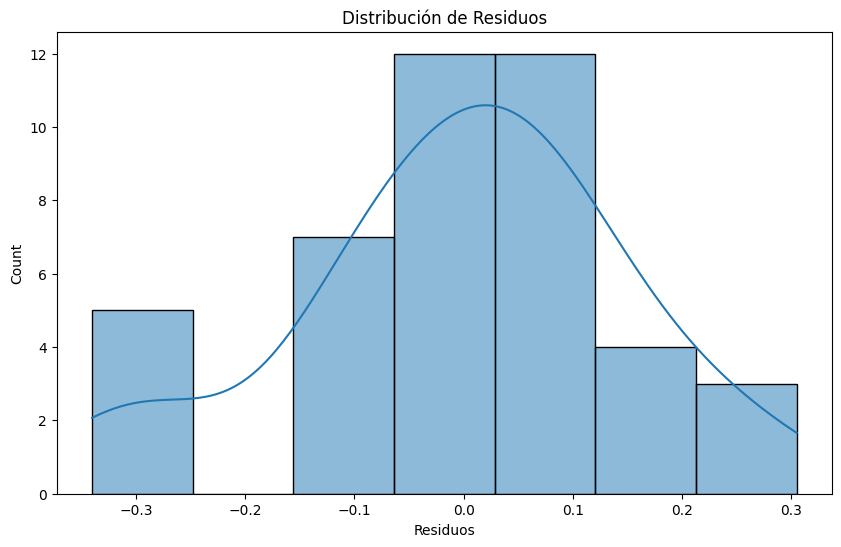

In [45]:
# 2. Distribución de Residuos
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuos')
plt.title('Distribución de Residuos')
plt.show()

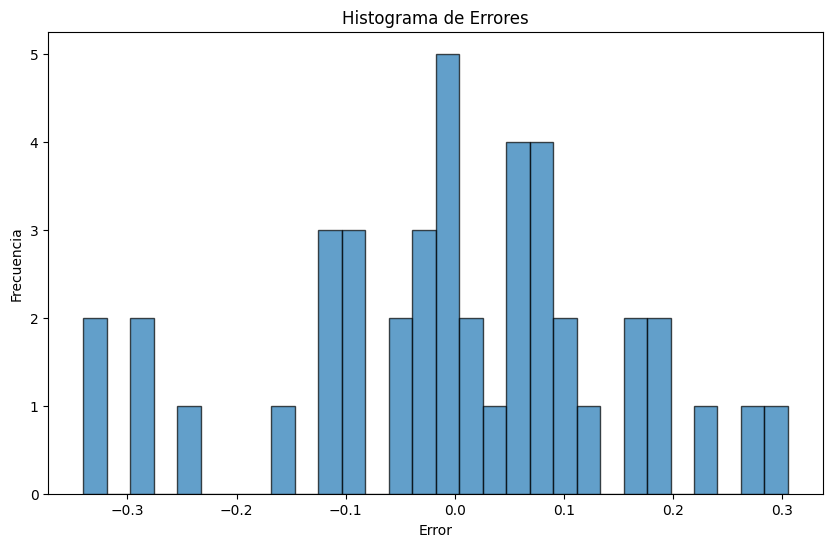

In [46]:
# 3. Histograma de Errores
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.title('Histograma de Errores')
plt.show()

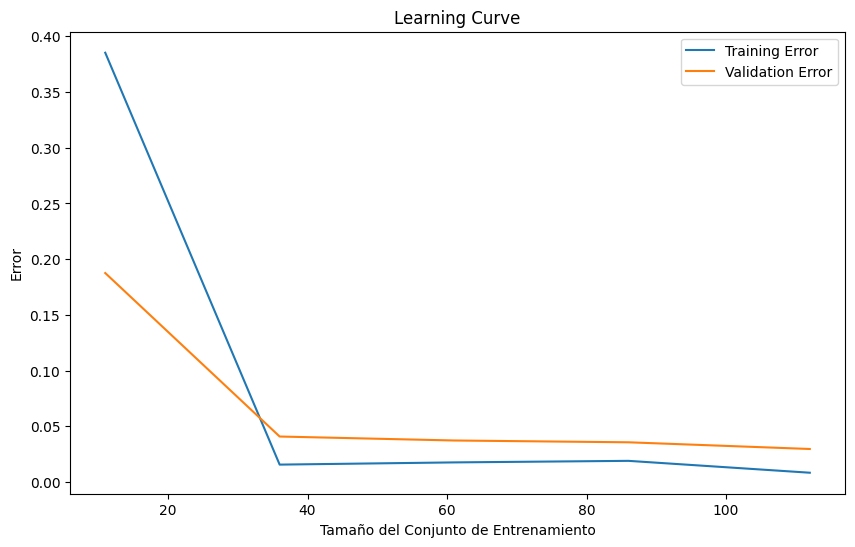

In [47]:
with parallel_backend('loky'):
  # 1. Reducir el tamaño del conjunto de datos
  sample_size = 4000
  if len(X_train) > sample_size:
      X_train_sample = X_train[:sample_size]
      Y_train_sample = Y_train[:sample_size]
  else:
      X_train_sample = X_train
      Y_train_sample = Y_train

  # 2. Ajustar el número de trabajos paralelos
  n_jobs_optimized = 6  # Ajustar este valor según la capacidad del CPU

  # 3. Generar la curva de aprendizaje con el tamaño de muestra reducido
  train_sizes, train_scores, test_scores = learning_curve(
      stacking_model, X_train_sample, Y_train_sample, cv=3, scoring='neg_mean_squared_error', n_jobs=n_jobs_optimized,
      train_sizes=np.linspace(0.1, 1.0, 5)
  )

  # 4. Calcular las medias de los puntajes
  train_scores_mean = -train_scores.mean(axis=1)
  test_scores_mean = -test_scores.mean(axis=1)

# 5. Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Error')
plt.plot(train_sizes, test_scores_mean, label='Validation Error')
plt.xlabel('Tamaño del Conjunto de Entrenamiento')
plt.ylabel('Error')
plt.title('Learning Curve')
plt.legend()
plt.show()

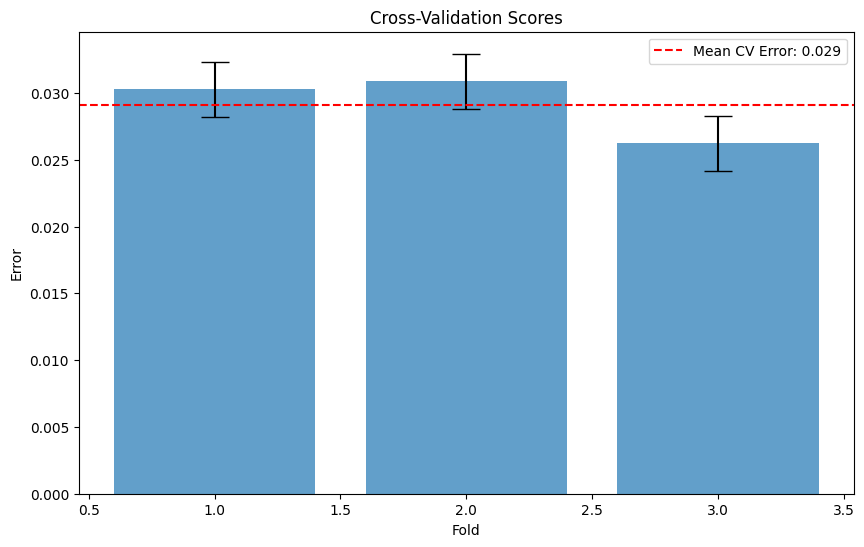

In [49]:
# Realizar la validación cruzada con el backend 'loky'
with parallel_backend('loky'):
    cv_scores = cross_val_score(stacking_model, X_train_sample, Y_train_sample, cv=3, scoring='neg_mean_squared_error', n_jobs=n_jobs_optimized)

# Calcular la media y la desviación estándar de los puntajes
cv_scores_mean = -cv_scores.mean()
cv_scores_std = cv_scores.std()

# Graficar los resultados de la validación cruzada
plt.figure(figsize=(10, 6))
plt.bar(range(1, 4), -cv_scores, yerr=cv_scores_std, align='center', alpha=0.7, capsize=10)
plt.axhline(y=cv_scores_mean, color='r', linestyle='--', label=f'Mean CV Error: {cv_scores_mean:.3f}')
plt.xlabel('Fold')
plt.ylabel('Error')
plt.title('Cross-Validation Scores')
plt.legend()
plt.show()

In [50]:
X_train.shape

(169, 881)

# **Modelo MLM para generación de nuevos compuestos químicos**



In [51]:
# Cargar el dataset
ruta_archivo_bioactivity = '/content/drive/My Drive/Colab Notebooks/data/bioactivity_data_2class_pIC50.csv'

# Lee el archivo CSV en un DataFrame
df = pd.read_csv(ruta_archivo_bioactivity)

# Mostrar que se haya importado correctamente el archivo
df

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL192660,NCCCCCCNc1nsc2nccn12,inactive,239.348,1.72180,2.0,6.0,4.958607
1,CHEMBL190568,O=S(=O)(NCCCCCCNc1nsc2nccn12)c1ccccc1,intermediate,379.511,2.74160,2.0,7.0,5.638272
2,CHEMBL365470,Cc1ccccc1S(=O)(=O)NCCCCCCNc1nsc2nccn12,active,393.538,3.05002,2.0,7.0,6.154902
3,CHEMBL189379,Cc1ccc(S(=O)(=O)NCCCCCCNc2nsc3nccn23)cc1,intermediate,393.538,3.05002,2.0,7.0,5.657577
4,CHEMBL193212,O=[N+]([O-])c1ccccc1S(=O)(=O)NCCCCCCNc1nsc2nccn12,active,424.508,2.64980,2.0,9.0,6.886057
...,...,...,...,...,...,...,...,...
266,CHEMBL4878636,CC(NNC(=O)c1ccc(C(F)(F)F)cc1)C12CC3CC(CC(C3)C1)C2,active,366.427,4.54470,2.0,2.0,6.288193
267,CHEMBL4872088,CCC12CC3CC(C1)CC(NNC(=O)c1ccc(C(F)(F)F)cc1)(C3)C2,intermediate,366.427,4.68880,2.0,2.0,5.779892
268,CHEMBL4856490,CC12CC3CC(C1)CC(NC(=O)c1ccc(C(F)(F)F)cc1)(C3)C2,intermediate,337.385,4.79410,1.0,1.0,5.046724
269,CHEMBL1257073,O=C(NN1C(=O)[C@@H]2[C@@H]3C=C[C@@H]([C@H]4C[C@...,active,376.334,2.40330,1.0,3.0,8.575118


## **Carga del modelo pre-entrenado con finetuning**

In [52]:
# Verificar si CUDA está disponible y definir el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device in use: {device}')

Device in use: cuda


In [53]:
# Cargar el modelo y el tokenizador entrenados
model_name = "/content/drive/My Drive/Colab Notebooks/data/results"  # Directorio donde se guardaron los resultados del entrenamiento
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = RobertaForCausalLM.from_pretrained(model_name, is_decoder=True)  # Asegúrate de configurar el modelo como decodificador

# Crear el pipeline de fill-mask usando el modelo afinado
fill_mask = pipeline(
    "fill-mask",
    model=model,
    tokenizer=tokenizer,
    device=0  # 'device' se establece en 0 para usar la primera GPU disponible
)

OSError: Incorrect path_or_model_id: '/content/drive/My Drive/Colab Notebooks/data/results'. Please provide either the path to a local folder or the repo_id of a model on the Hub.

## **Funciones para generación de SMILES**

In [ ]:
# Función para validar SMILES
def is_valid_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol is not None

In [ ]:
# Función para remover átomos y agregar *
def remove_atoms_and_placeholder(smiles, num_atoms_to_remove=1):
    # Redirigir stderr para silenciar errores de RDKit
    stderr = sys.stderr
    sys.stderr = open(os.devnull, 'w')

    try:
        # Convertir SMILES a una molécula RDKit
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None, None

        # Seleccionar átomos al azar para eliminar
        atoms_to_remove = sample(range(mol.GetNumAtoms()), num_atoms_to_remove)

        # Crear una copia editable de la molécula
        mol_edit = rdchem.RWMol(mol)

        # Remover átomos
        for idx in sorted(atoms_to_remove, reverse=True):
            mol_edit.ReplaceAtom(idx, rdchem.Atom('*'))

        # Convertir la molécula modificada de nuevo a SMILES
        modified_smiles = Chem.MolToSmiles(mol_edit)

    finally:
        # Restaurar stderr
        sys.stderr.close()
        sys.stderr = stderr

    return modified_smiles, atoms_to_remove

In [ ]:
%%capture
# Ejemplo de múltiples secuencias SMILES con placeholders en diferentes posiciones
smiles_list = df['canonical_smiles']

# DataFrame para almacenar los resultados
results_list = []

# Generar secuencias completas para cada SMILES en la lista
for idx, smiles in enumerate(smiles_list):
    modified_smiles, removed_atoms = remove_atoms_and_placeholder(smiles, num_atoms_to_remove=1)
    if modified_smiles:
            modified_smiles_with_mask = modified_smiles.replace('*', '<mask>')

            # Usar el pipeline para llenar las máscaras
            results = fill_mask(modified_smiles_with_mask)

            # Procesar los resultados y almacenar en la lista de resultados
            for res in results:
                sequence = res['sequence']
                sequence = sequence.replace('<s>', '').replace('</s>', '').strip()
                if is_valid_smiles(sequence):
                    results_list.append({
                        'Original_SMILES': smiles,
                        'Modified_SMILES': sequence,
                        'Group': idx
                    })

# Crear el DataFrame a partir de la lista de resultados
results_df = pd.DataFrame(results_list)

# Filtrar filas donde el Original_SMILES sea igual al Modified_SMILES
results_df = results_df[results_df['Original_SMILES'] != results_df['Modified_SMILES']]

In [ ]:
# Mostrar el DataFrame resultante
results_df = results_df.reset_index(drop=True)
results_df

,Original_SMILES,Modified_SMILES,Group
0,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,0
1,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,0
2,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,1
3,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,1
4,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,2
...,...,...,...
17377,CN1C(C)(C)CC(Nc2nc3c(-c4ccc(C(=O)N5C[C@@H]6C[C...,CN1C(C)(C)CC(Nc2nc3:ncc(c4ccc(C(=O)N5C[C@@H]6C...,10632
17378,COC(=O)N1CCN(C(=O)c2ccc(-c3cnn4c(N)c(-c5ccccc5...,OC(=O)N1CCN(C(=O)c2ccc(-c3cnn4c(N)c(-c5ccccc5)...,10633
17379,COC(=O)N1CCN(C(=O)c2ccc(-c3cnn4c(N)c(-c5ccccc5...,CSOC(=O)N1CCN(C(=O)c2ccc(-c3cnn4c(N)c(-c5ccccc...,10633
17380,CN1C(C)(C)CC(Nc2nc3c(-c4ccc(C(=O)N5CCN(S(C)(=O...,CN1C(C)(C)CC(Nc2nc3c(-c4ccc(C(=O)N5C\N(S(C)(=O...,10634


In [ ]:
# Seleccionar solo la columna 'molecule_chembl_id' del DataFrame original
df_subset = df[['molecule_chembl_id', 'class']]

# Añadir la columna 'molecule_chembl_id' al DataFrame results_df
merged_df = pd.merge(results_df, df_subset, left_on='Group', right_index=True)

In [ ]:
# Mostrar el DataFrame resultante
merged_df = merged_df.reset_index(drop=True)
merged_df

,Original_SMILES,Modified_SMILES,Group,molecule_chembl_id,class
0,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,0,CHEMBL2022564,active
1,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,0,CHEMBL2022564,active
2,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,1,CHEMBL3234200,active
3,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,1,CHEMBL3234200,active
4,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,2,CHEMBL3234201,active
...,...,...,...,...,...
17377,CN1C(C)(C)CC(Nc2nc3c(-c4ccc(C(=O)N5C[C@@H]6C[C...,CN1C(C)(C)CC(Nc2nc3:ncc(c4ccc(C(=O)N5C[C@@H]6C...,10632,CHEMBL4636056,intermediate
17378,COC(=O)N1CCN(C(=O)c2ccc(-c3cnn4c(N)c(-c5ccccc5...,OC(=O)N1CCN(C(=O)c2ccc(-c3cnn4c(N)c(-c5ccccc5)...,10633,CHEMBL4643578,active
17379,COC(=O)N1CCN(C(=O)c2ccc(-c3cnn4c(N)c(-c5ccccc5...,CSOC(=O)N1CCN(C(=O)c2ccc(-c3cnn4c(N)c(-c5ccccc...,10633,CHEMBL4643578,active
17380,CN1C(C)(C)CC(Nc2nc3c(-c4ccc(C(=O)N5CCN(S(C)(=O...,CN1C(C)(C)CC(Nc2nc3c(-c4ccc(C(=O)N5C\N(S(C)(=O...,10634,CHEMBL4639022,intermediate


In [ ]:
# Remover moléculas modificadas que sean iguales a las originales
merged_df = merged_df[merged_df['Original_SMILES'] != merged_df['Modified_SMILES']]
merged_df

,Original_SMILES,Modified_SMILES,Group,molecule_chembl_id,class
0,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,0,CHEMBL2022564,active
1,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,0,CHEMBL2022564,active
2,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,1,CHEMBL3234200,active
3,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,1,CHEMBL3234200,active
4,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,2,CHEMBL3234201,active
...,...,...,...,...,...
17377,CN1C(C)(C)CC(Nc2nc3c(-c4ccc(C(=O)N5C[C@@H]6C[C...,CN1C(C)(C)CC(Nc2nc3:ncc(c4ccc(C(=O)N5C[C@@H]6C...,10632,CHEMBL4636056,intermediate
17378,COC(=O)N1CCN(C(=O)c2ccc(-c3cnn4c(N)c(-c5ccccc5...,OC(=O)N1CCN(C(=O)c2ccc(-c3cnn4c(N)c(-c5ccccc5)...,10633,CHEMBL4643578,active
17379,COC(=O)N1CCN(C(=O)c2ccc(-c3cnn4c(N)c(-c5ccccc5...,CSOC(=O)N1CCN(C(=O)c2ccc(-c3cnn4c(N)c(-c5ccccc...,10633,CHEMBL4643578,active
17380,CN1C(C)(C)CC(Nc2nc3c(-c4ccc(C(=O)N5CCN(S(C)(=O...,CN1C(C)(C)CC(Nc2nc3c(-c4ccc(C(=O)N5C\N(S(C)(=O...,10634,CHEMBL4639022,intermediate


In [ ]:
# Agregar identificador para las nuevas moleculas
merged_df['molecule_id'] = range(1, len(merged_df) + 1)

In [ ]:
# Guardamos el DataFrame con la lista de todos los Modified_SMILES válidos
merged_df.to_csv('/content/drive/My Drive/Colab Notebooks/data/bioactivity_data_new_molecules.csv', index=False)

In [ ]:
# Cargar CSV
merged_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/bioactivity_data_new_molecules.csv')

In [ ]:
# Mostrar df
merged_df

,Original_SMILES,Modified_SMILES,Group,molecule_chembl_id,class,molecule_id
0,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,0,CHEMBL2022564,active,1
1,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,0,CHEMBL2022564,active,2
2,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,1,CHEMBL3234200,active,3
3,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,1,CHEMBL3234200,active,4
4,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,2,CHEMBL3234201,active,5
...,...,...,...,...,...,...
17377,CN1C(C)(C)CC(Nc2nc3c(-c4ccc(C(=O)N5C[C@@H]6C[C...,CN1C(C)(C)CC(Nc2nc3:ncc(c4ccc(C(=O)N5C[C@@H]6C...,10632,CHEMBL4636056,intermediate,17378
17378,COC(=O)N1CCN(C(=O)c2ccc(-c3cnn4c(N)c(-c5ccccc5...,OC(=O)N1CCN(C(=O)c2ccc(-c3cnn4c(N)c(-c5ccccc5)...,10633,CHEMBL4643578,active,17379
17379,COC(=O)N1CCN(C(=O)c2ccc(-c3cnn4c(N)c(-c5ccccc5...,CSOC(=O)N1CCN(C(=O)c2ccc(-c3cnn4c(N)c(-c5ccccc...,10633,CHEMBL4643578,active,17380
17380,CN1C(C)(C)CC(Nc2nc3c(-c4ccc(C(=O)N5CCN(S(C)(=O...,CN1C(C)(C)CC(Nc2nc3c(-c4ccc(C(=O)N5C\N(S(C)(=O...,10634,CHEMBL4639022,intermediate,17381


# Generar fingerprints para las nuevas moleculas

In [ ]:
# Columnas de interés para el descriptor PADEL
columnas = ['Modified_SMILES','molecule_id']
df_selection = merged_df[columnas]
df_selection

,Modified_SMILES,molecule_id
0,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,1
1,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,2
2,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,3
3,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,4
4,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,5
...,...,...
17377,CN1C(C)(C)CC(Nc2nc3:ncc(c4ccc(C(=O)N5C[C@@H]6C...,17378
17378,OC(=O)N1CCN(C(=O)c2ccc(-c3cnn4c(N)c(-c5ccccc5)...,17379
17379,CSOC(=O)N1CCN(C(=O)c2ccc(-c3cnn4c(N)c(-c5ccccc...,17380
17380,CN1C(C)(C)CC(Nc2nc3c(-c4ccc(C(=O)N5C\N(S(C)(=O...,17381


In [ ]:
# Guardar en un archivo SMI
# En drive
df_selection.to_csv('/content/drive/My Drive/Colab Notebooks/data/new_molecule.smi', sep='\t', index=False, header=False)
# Local
df_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [ ]:
# Visualizar molecula
! cat '/content/drive/My Drive/Colab Notebooks/data/new_molecule.smi' | head -5

CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(C)(C)C)C[C@@H](C)C[C@H](O)[C@H](C)C2=N[C@@H](CCC(=O)N[C@@H](Cc3ccc(OC)cc3)OC(=O)N(C)[C@@H](C)C(=O)N1C)CS2	1
CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(C)(C)C)C[C@@H](C)C[C@H](O)[C@H](C)C2=N[C@@H](CCC(=O)N[C@@H](Cc3ccc(OC)cc3)CC(=O)N(C)[C@@H](C)C(=O)N1C)CS2	2
CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(C)(C)C)C[C@@H](C)C[C@H](O)CC2=N[C@@H](CCC(=O)N[C@@H](Cc3cc:C(OC):cc3)C(=O)N(C)[C@@H](C)C(=O)N1C)CS2	3
CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(C)(C)C)C[C@@H](C)C[C@H](O)CC2=N[C@@H](CCC(=O)N[C@@H](Cc3cc:OC(OC):cc3)C(=O)N(C)[C@@H](C)C(=O)N1C)CS2	4
CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(C)(C)C)C[C@@H](C)C[C@H](O)C(C)(C)C2=N[C@@H](CCC(=O)N[C@@H](OCc3ccc(OC)cc3)C(=O)N(C)[C@@H](C)C(=O)N1C)CS2	5


In [ ]:
# Número de registros
! cat '/content/drive/My Drive/Colab Notebooks/data/new_molecule.smi' | wc -l

17382


# **Cálculo de descriptores con PaDEL**


In [ ]:
%%capture
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh

!cp "padel.zip" "/content/drive/My Drive/Colab Notebooks/data/padel.zip"
!cp "padel.sh" "/content/drive/My Drive/Colab Notebooks/data/padel.sh"

!cp "/content/drive/My Drive/Colab Notebooks/data/padel.zip" "padel.zip"
!cp "/content/drive/My Drive/Colab Notebooks/data/padel.sh" "padel.sh"

In [ ]:
# Descomprimimos padel sin Output en consola
%%capture
! unzip padel.zip

In [ ]:
# Inspeccionamos el script de PaDEL que nos ayudará a generar los descriptores
! cat padel.sh

java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor/PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./PaDEL-Descriptor/PubchemFingerprinter.xml -dir ./ -file descriptors_output.csv


In [ ]:
# Calculamos los descriptores con PaDEL sin Output en consola
%%capture
! bash padel.sh

In [ ]:
# Guardamos el output como csv
!cp "descriptors_output.csv" "/content/drive/My Drive/Colab Notebooks/data/descriptors_output_new_mol.csv"

In [ ]:
# Mostrar descriptores calculados con Padel
fingerprints_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/descriptors_output_new_mol.csv')
fingerprints_df

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17377,17378,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17378,17379,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17379,17380,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17380,17381,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Guardar en drive el dataset
fingerprints_df.to_csv('/content/drive/My Drive/Colab Notebooks/data/pubchem_fp_new_mol.csv', index=False)

# **Predicción de pIC50 para nuevas moléculas**

In [ ]:
# Usar nuevo dataset
df_new_mol = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/pubchem_fp_new_mol.csv')
df_new_mol

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17377,17378,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17378,17379,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17379,17380,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17380,17381,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Se define conjunto X_new_mol para los fingerprints de las nuevas moléculas
X_new_mol = df_new_mol.drop('Name', axis=1)
# Mostrar contenido en el conjunto de X_new_mol
X_new_mol

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17377,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
17378,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
17379,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
17380,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Prediccion valores pIC50
Y_pred_new_mol = stacking_model.predict(X_new_mol)

NameError: name 'stacking_model' is not defined

In [ ]:
# Guardar el modelo en un archivo
joblib.dump(stacking_model, '/content/drive/My Drive/Colab Notebooks/data/stacking_model.pkl')

['/content/drive/My Drive/Colab Notebooks/data/stacking_model.pkl']

El anterior modelo se carga de la siguiente forma:



```
# Cargar el modelo desde el archivo
stacking_model = joblib.load('stacking_model.pkl')

# Usar el modelo para hacer predicciones
Y_pred_new_mol = stacking_model.predict(X_new_mol)
```



# **Nuevas moléculas con mejor pIC50**

In [ ]:
# Cargar el modelo desde el archivo
stacking_model = joblib.load('/content/drive/My Drive/Colab Notebooks/data/stacking_model.pkl')

# Usar el modelo para hacer predicciones
Y_pred_new_mol = stacking_model.predict(X_new_mol)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ValueError: node array from the pickle has an incompatible dtype:
- expected: {'names': ['left_child', 'right_child', 'feature', 'threshold', 'impurity', 'n_node_samples', 'weighted_n_node_samples', 'missing_go_to_left'], 'formats': ['<i8', '<i8', '<i8', '<f8', '<f8', '<i8', '<f8', 'u1'], 'offsets': [0, 8, 16, 24, 32, 40, 48, 56], 'itemsize': 64}
- got     : [('left_child', '<i8'), ('right_child', '<i8'), ('feature', '<i8'), ('threshold', '<f8'), ('impurity', '<f8'), ('n_node_samples', '<i8'), ('weighted_n_node_samples', '<f8')]

In [ ]:
# Obtener las posiciones de las 10 predicciones más altas
top_10_indices = Y_pred_new_mol.argsort()[:][::-1]

# Obtener los nombres (Name) de estas moléculas
top_10_names = df_new_mol.iloc[top_10_indices]['Name'].values

# Filtrar fingerprints_df para obtener molecule_id
top_10_ids = fingerprints_df[fingerprints_df['Name'].isin(top_10_names)]

# Unir con df_selection para obtener las SMILES canónicas
top_10_smiles = df_selection[df_selection['molecule_id'].isin(top_10_ids['Name'])]

# Unir los resultados para tener un dataframe con SMILES y pIC50
result = top_10_smiles.merge(top_10_ids, left_on='molecule_id', right_on='Name')
result['pIC50'] = Y_pred_new_mol[top_10_indices]

# Seleccionar las columnas de interés
result = result[['Modified_SMILES', 'pIC50']]

# Mostrar las primeras 10 moléculas con mayor pIC50 y sus SMILES
result


,Modified_SMILES,pIC50
0,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,0.873622
1,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,0.854798
2,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,0.854037
3,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,0.853759
4,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,0.853759
...,...,...
17377,CN1C(C)(C)CC(Nc2nc3:ncc(c4ccc(C(=O)N5C[C@@H]6C...,0.107076
17378,OC(=O)N1CCN(C(=O)c2ccc(-c3cnn4c(N)c(-c5ccccc5)...,0.105236
17379,CSOC(=O)N1CCN(C(=O)c2ccc(-c3cnn4c(N)c(-c5ccccc...,0.104101
17380,CN1C(C)(C)CC(Nc2nc3c(-c4ccc(C(=O)N5C\N(S(C)(=O...,0.099439


In [ ]:
# Exportar a csv el dataset
result.to_csv('/content/drive/My Drive/Colab Notebooks/data/new_molecule_pIC50.csv', index=False)

In [ ]:
# Guardar archivos en un archivo zip
! zip -r /content/drive/My\ Drive/Colab\ Notebooks/data/results.zip /content/drive/My\ Drive/Colab\ Notebooks/data

updating: content/drive/My Drive/Colab Notebooks/data/plot_bioactivity_class.pdf (deflated 38%)
updating: content/drive/My Drive/Colab Notebooks/data/plot_ic50.pdf (deflated 37%)
updating: content/drive/My Drive/Colab Notebooks/data/plot_LogP.pdf (deflated 37%)
updating: content/drive/My Drive/Colab Notebooks/data/plot_MW.pdf (deflated 38%)
updating: content/drive/My Drive/Colab Notebooks/data/plot_MW_vs_LogP.pdf (deflated 1%)
updating: content/drive/My Drive/Colab Notebooks/data/plot_NumHAcceptors.pdf (deflated 39%)
updating: content/drive/My Drive/Colab Notebooks/data/plot_NumHDonors.pdf (deflated 39%)
updating: content/drive/My Drive/Colab Notebooks/data/bioactivity_data_2class_pIC50.csv (deflated 78%)
updating: content/drive/My Drive/Colab Notebooks/data/bioactivity_data.csv (deflated 92%)
updating: content/drive/My Drive/Colab Notebooks/data/bioactivity_data_curated.csv (deflated 83%)
updating: content/drive/My Drive/Colab Notebooks/data/bioactivity_data_preprocessed.csv (deflated



---

### Comparación moléculas modificadas vs moléculas originales





In [ ]:
# Cargar el dataset
ruta_archivo_modified_molecules = '/content/drive/My Drive/Colab Notebooks/data/new_molecule_pIC50.csv'

# Lee el archivo CSV en un DataFrame
df_modified_molecules = pd.read_csv(ruta_archivo_modified_molecules)

# Mostrar que se haya importado correctamente el archivo
df_modified_molecules

,Modified_SMILES,pIC50
0,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,0.873622
1,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,0.854798
2,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,0.854037
3,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,0.853759
4,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,0.853759
...,...,...
17377,CN1C(C)(C)CC(Nc2nc3:ncc(c4ccc(C(=O)N5C[C@@H]6C...,0.107076
17378,OC(=O)N1CCN(C(=O)c2ccc(-c3cnn4c(N)c(-c5ccccc5)...,0.105236
17379,CSOC(=O)N1CCN(C(=O)c2ccc(-c3cnn4c(N)c(-c5ccccc...,0.104101
17380,CN1C(C)(C)CC(Nc2nc3c(-c4ccc(C(=O)N5C\N(S(C)(=O...,0.099439


In [ ]:
# Cargar el dataset
ruta_archivo_new_molecules = '/content/drive/My Drive/Colab Notebooks/data/bioactivity_data_new_molecules.csv'

# Lee el archivo CSV en un DataFrame
df_new_molecules = pd.read_csv(ruta_archivo_new_molecules)

# Mostrar que se haya importado correctamente el archivo
df_new_molecules

,Original_SMILES,Modified_SMILES,Group,molecule_chembl_id,class,molecule_id
0,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,0,CHEMBL2022564,active,1
1,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,0,CHEMBL2022564,active,2
2,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,1,CHEMBL3234200,active,3
3,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,1,CHEMBL3234200,active,4
4,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,2,CHEMBL3234201,active,5
...,...,...,...,...,...,...
17377,CN1C(C)(C)CC(Nc2nc3c(-c4ccc(C(=O)N5C[C@@H]6C[C...,CN1C(C)(C)CC(Nc2nc3:ncc(c4ccc(C(=O)N5C[C@@H]6C...,10632,CHEMBL4636056,intermediate,17378
17378,COC(=O)N1CCN(C(=O)c2ccc(-c3cnn4c(N)c(-c5ccccc5...,OC(=O)N1CCN(C(=O)c2ccc(-c3cnn4c(N)c(-c5ccccc5)...,10633,CHEMBL4643578,active,17379
17379,COC(=O)N1CCN(C(=O)c2ccc(-c3cnn4c(N)c(-c5ccccc5...,CSOC(=O)N1CCN(C(=O)c2ccc(-c3cnn4c(N)c(-c5ccccc...,10633,CHEMBL4643578,active,17380
17380,CN1C(C)(C)CC(Nc2nc3c(-c4ccc(C(=O)N5CCN(S(C)(=O...,CN1C(C)(C)CC(Nc2nc3c(-c4ccc(C(=O)N5C\N(S(C)(=O...,10634,CHEMBL4639022,intermediate,17381


In [ ]:
# Asegurarse de que ambos DataFrames tienen la columna 'Modified_SMILES' para realizar la fusión
# Fusionar los DataFrames usando 'Modified_SMILES' como clave
merged_df_original_modified = pd.merge(df_modified_molecules, df_new_molecules[['Modified_SMILES', 'Original_SMILES', 'molecule_chembl_id', 'class']], on='Modified_SMILES', how='inner')

# Renombrar la columna 'pIC50' a 'Predicted_pIC50'
merged_df_original_modified = merged_df_original_modified.rename(columns={'pIC50': 'Predicted_pIC50'})

# Mostrar el DataFrame resultante
merged_df_original_modified

,Modified_SMILES,Predicted_pIC50,Original_SMILES,molecule_chembl_id,class
0,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,0.873622,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CHEMBL2022564,active
1,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,0.854798,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CHEMBL2022564,active
2,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,0.854037,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CHEMBL3234200,active
3,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,0.853759,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CHEMBL3234200,active
4,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,0.853759,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CHEMBL3234201,active
...,...,...,...,...,...
17399,CN1C(C)(C)CC(Nc2nc3:ncc(c4ccc(C(=O)N5C[C@@H]6C...,0.107076,CN1C(C)(C)CC(Nc2nc3c(-c4ccc(C(=O)N5C[C@@H]6C[C...,CHEMBL4636056,intermediate
17400,OC(=O)N1CCN(C(=O)c2ccc(-c3cnn4c(N)c(-c5ccccc5)...,0.105236,COC(=O)N1CCN(C(=O)c2ccc(-c3cnn4c(N)c(-c5ccccc5...,CHEMBL4643578,active
17401,CSOC(=O)N1CCN(C(=O)c2ccc(-c3cnn4c(N)c(-c5ccccc...,0.104101,COC(=O)N1CCN(C(=O)c2ccc(-c3cnn4c(N)c(-c5ccccc5...,CHEMBL4643578,active
17402,CN1C(C)(C)CC(Nc2nc3c(-c4ccc(C(=O)N5C\N(S(C)(=O...,0.099439,CN1C(C)(C)CC(Nc2nc3c(-c4ccc(C(=O)N5CCN(S(C)(=O...,CHEMBL4639022,intermediate


In [ ]:
# Supongamos que estos eran los valores mínimo y máximo originales de pIC50
min_pIC50 = 2.389233405226729  # Reemplaza con el valor mínimo original de pIC50
max_pIC50 = 10.638272163982407 # Reemplaza con el valor máximo original de pIC50

# Función para desescalar manualmente
def invert_scaling(scaled_value, min_val, max_val):
    return scaled_value * (max_val - min_val) + min_val

# Aplicar la función de desescalado manualmente
merged_df_original_modified['Predicted_pIC50'] = merged_df_original_modified['Predicted_pIC50'].apply(invert_scaling, args=(min_pIC50, max_pIC50))

merged_df_original_modified

,Modified_SMILES,Predicted_pIC50,Original_SMILES,molecule_chembl_id,class
0,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,9.595773,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CHEMBL2022564,active
1,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,9.440497,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CHEMBL2022564,active
2,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,9.434220,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CHEMBL3234200,active
3,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,9.431921,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CHEMBL3234200,active
4,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,9.431921,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CHEMBL3234201,active
...,...,...,...,...,...
17399,CN1C(C)(C)CC(Nc2nc3:ncc(c4ccc(C(=O)N5C[C@@H]6C...,3.272506,CN1C(C)(C)CC(Nc2nc3c(-c4ccc(C(=O)N5C[C@@H]6C[C...,CHEMBL4636056,intermediate
17400,OC(=O)N1CCN(C(=O)c2ccc(-c3cnn4c(N)c(-c5ccccc5)...,3.257328,COC(=O)N1CCN(C(=O)c2ccc(-c3cnn4c(N)c(-c5ccccc5...,CHEMBL4643578,active
17401,CSOC(=O)N1CCN(C(=O)c2ccc(-c3cnn4c(N)c(-c5ccccc...,3.247970,COC(=O)N1CCN(C(=O)c2ccc(-c3cnn4c(N)c(-c5ccccc5...,CHEMBL4643578,active
17402,CN1C(C)(C)CC(Nc2nc3c(-c4ccc(C(=O)N5C\N(S(C)(=O...,3.209510,CN1C(C)(C)CC(Nc2nc3c(-c4ccc(C(=O)N5CCN(S(C)(=O...,CHEMBL4639022,intermediate


In [ ]:
# Cargar el dataset que tiene los pIC50 originales de la molécula
ruta_archivo_bioactivity_all = '/content/drive/My Drive/Colab Notebooks/data/bioactivity_data_2class_pIC50.csv'

# Lee el archivo CSV en un DataFrame
df_main_all_pIC50 = pd.read_csv(ruta_archivo_bioactivity_all)

# Mostrar que se haya importado correctamente el archivo
df_main_all_pIC50

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL2022564,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,active,828.130,5.1124,2.0,10.0,9.494850
1,CHEMBL3234200,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,active,814.103,4.8664,2.0,10.0,9.522879
2,CHEMBL3234201,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,active,842.157,5.5025,2.0,10.0,9.327902
3,CHEMBL3234202,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,active,828.130,5.1124,2.0,10.0,9.920819
4,CHEMBL3649592,CC1CCC(NCc2ccn(Cc3ccccc3)c(=O)c2O)CC1,inactive,326.440,3.2705,2.0,4.0,4.562249
...,...,...,...,...,...,...,...,...
10630,CHEMBL4636800,COc1ccc(-c2cnn3c(N)c(-c4ccccc4)c(NCCCN(C)C)nc2...,intermediate,446.555,4.0263,2.0,8.0,5.102373
10631,CHEMBL4644274,COc1ccc(-c2cnn3c(N)c(-c4ccccc4)c(NC4CC(C)(C)N(...,active,514.674,5.7260,2.0,8.0,6.004365
10632,CHEMBL4636056,CN1C(C)(C)CC(Nc2nc3c(-c4ccc(C(=O)N5C[C@@H]6C[C...,intermediate,579.749,5.3221,2.0,8.0,5.886057
10633,CHEMBL4643578,COC(=O)N1CCN(C(=O)c2ccc(-c3cnn4c(N)c(-c5ccccc5...,active,624.790,5.2330,2.0,9.0,6.050610


In [ ]:
# Fusionar los DataFrames usando 'molecule_chembl_id' como clave
merged_df_original_modified = pd.merge(merged_df_original_modified, df_main_all_pIC50[['molecule_chembl_id', 'pIC50']], on='molecule_chembl_id', how='left')

# Renombrar la columna 'pIC50' a 'Original_pIC50'
merged_df_original_modified = merged_df_original_modified.rename(columns={'pIC50': 'Original_pIC50'})

# Mostrar el DataFrame resultante
merged_df_original_modified

,Modified_SMILES,Predicted_pIC50,Original_SMILES,molecule_chembl_id,class,Original_pIC50
0,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,9.595773,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CHEMBL2022564,active,9.494850
1,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,9.440497,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CHEMBL2022564,active,9.494850
2,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,9.434220,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CHEMBL3234200,active,9.522879
3,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,9.431921,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CHEMBL3234200,active,9.522879
4,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,9.431921,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CHEMBL3234201,active,9.327902
...,...,...,...,...,...,...
17399,CN1C(C)(C)CC(Nc2nc3:ncc(c4ccc(C(=O)N5C[C@@H]6C...,3.272506,CN1C(C)(C)CC(Nc2nc3c(-c4ccc(C(=O)N5C[C@@H]6C[C...,CHEMBL4636056,intermediate,5.886057
17400,OC(=O)N1CCN(C(=O)c2ccc(-c3cnn4c(N)c(-c5ccccc5)...,3.257328,COC(=O)N1CCN(C(=O)c2ccc(-c3cnn4c(N)c(-c5ccccc5...,CHEMBL4643578,active,6.050610
17401,CSOC(=O)N1CCN(C(=O)c2ccc(-c3cnn4c(N)c(-c5ccccc...,3.247970,COC(=O)N1CCN(C(=O)c2ccc(-c3cnn4c(N)c(-c5ccccc5...,CHEMBL4643578,active,6.050610
17402,CN1C(C)(C)CC(Nc2nc3c(-c4ccc(C(=O)N5C\N(S(C)(=O...,3.209510,CN1C(C)(C)CC(Nc2nc3c(-c4ccc(C(=O)N5CCN(S(C)(=O...,CHEMBL4639022,intermediate,5.958607


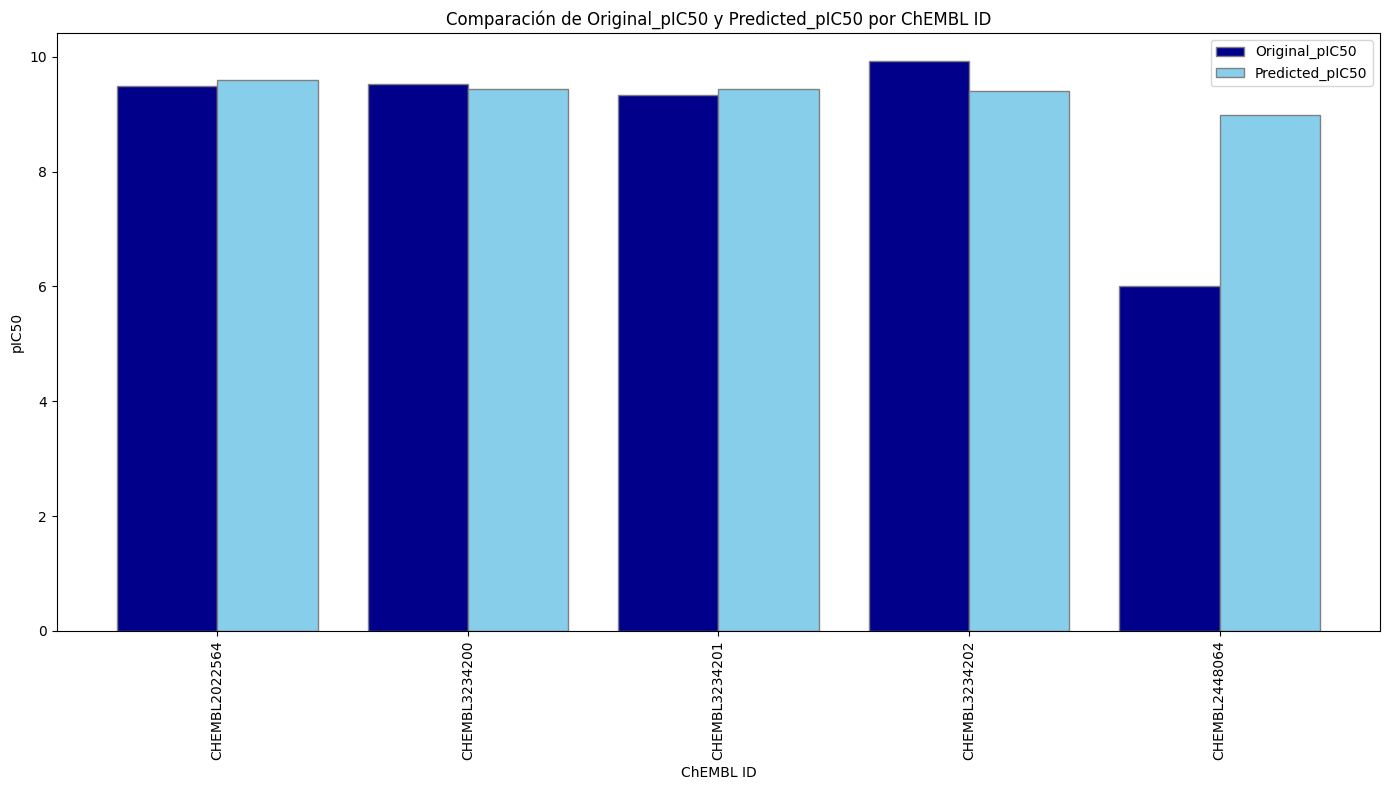

In [ ]:
# Filtrar solo los registros de la clase activa
active_df = merged_df_original_modified[merged_df_original_modified['class'] == 'active']

# Filtrar solo los 10 primeros registros únicos basados en molecule_chembl_id
top_unique_df = active_df.drop_duplicates(subset=['molecule_chembl_id']).head(5)

# Crear una figura y un conjunto de ejes
fig, ax = plt.subplots(figsize=(14, 8))

# Definir el ancho de las barras
bar_width = 0.4

# Crear un rango para las posiciones de las barras
r1 = np.arange(len(top_unique_df))
r2 = [x + bar_width for x in r1]

# Crear las barras para Original_pIC50
ax.bar(r1, top_unique_df['Original_pIC50'], color='darkblue', width=bar_width, edgecolor='grey', label='Original_pIC50')

# Crear las barras para Predicted_pIC50
ax.bar(r2, top_unique_df['Predicted_pIC50'], color='skyblue', width=bar_width, edgecolor='grey', label='Predicted_pIC50')

# Añadir etiquetas de ejes y título
ax.set_xlabel('ChEMBL ID')
ax.set_ylabel('pIC50')
ax.set_title('Comparación de Original_pIC50 y Predicted_pIC50 por ChEMBL ID')

# Añadir etiquetas de ticks en el eje x
ax.set_xticks([r + bar_width / 2 for r in range(len(top_unique_df))])
ax.set_xticklabels(top_unique_df['molecule_chembl_id'], rotation=90)

# Añadir leyenda
ax.legend()

# Ajustar el diseño
plt.tight_layout()

# Mostrar la gráfica
plt.show()

In [ ]:
# Filtrar solo los registros de la clase activa
active_df = merged_df_original_modified[merged_df_original_modified['class'] == 'active']

# Filtrar solo los 10 primeros registros únicos basados en molecule_chembl_id
top_unique_df = active_df.drop_duplicates(subset=['molecule_chembl_id']).head(10)
top_unique_df

,Modified_SMILES,Predicted_pIC50,Original_SMILES,molecule_chembl_id,class,Original_pIC50
0,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,9.595773,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CHEMBL2022564,active,9.494850
2,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,9.434220,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CHEMBL3234200,active,9.522879
4,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,9.431921,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CHEMBL3234201,active,9.327902
8,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,9.398483,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CHEMBL3234202,active,9.920819
42,COc1cc2c(NC3:ccc(Cl)cc:3F)ncnc2cc1OCC1CCNCC1.Cl,8.992768,COc1cc2c(Nc3ccc(Cl)cc3F)ncnc2cc1OCC1CCNCC1.Cl,CHEMBL2448064,active,6.000000
45,COc1cc2c(Nc3ccc(Cl)cc3F)ncnc2cc1OCCN(C)c1c:ccc...,8.948663,COc1cc2c(Nc3ccc(Cl)cc3F)ncnc2cc1OCCN(C)c1ccncc1,CHEMBL25579,active,7.000000
51,COc1cc2c(Nc3ccc(C):n:c3F)ncnc2cc1OCC1CCNCC1,8.916178,COc1cc2c(Nc3ccc(C)cc3F)ncnc2cc1OCC1CCNCC1,CHEMBL428534,active,6.154902
52,COc1cc2c(Nc3:n:cc(Br)cc3F)ncnc2cc1OCCn1ccnn1,8.912952,COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCCn1ccnn1,CHEMBL281872,active,6.154902
55,c1cc(Cl)cc(F)c1Nc1ncnc2cc(OCC3CCN(C)CC3)c(OC)cc12,8.908402,COc1cc2c(Nc3c(F)cc(Cl)cc3F)ncnc2cc1OCC1CCN(C)CC1,CHEMBL422758,active,6.522879
57,COc1cc2:S(Nc3c(F)cc(Cl)cc3F):ncnc2cc1OCC1CCNCC1,8.899259,COc1cc2c(Nc3c(F)cc(Cl)cc3F)ncnc2cc1OCC1CCNCC1,CHEMBL25450,active,6.346787


In [ ]:
# Filtrar solo los registros de la clase activa
active_df = merged_df_original_modified[merged_df_original_modified['class'] == 'active']

# Filtrar solo los 10 primeros registros únicos basados en molecule_chembl_id
top_unique_df_all = active_df.drop_duplicates(subset=['molecule_chembl_id'])
top_unique_df_all

,Modified_SMILES,Predicted_pIC50,Original_SMILES,molecule_chembl_id,class,Original_pIC50
0,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,9.595773,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CHEMBL2022564,active,9.494850
2,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,9.434220,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CHEMBL3234200,active,9.522879
4,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,9.431921,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CHEMBL3234201,active,9.327902
8,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,9.398483,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CHEMBL3234202,active,9.920819
42,COc1cc2c(NC3:ccc(Cl)cc:3F)ncnc2cc1OCC1CCNCC1.Cl,8.992768,COc1cc2c(Nc3ccc(Cl)cc3F)ncnc2cc1OCC1CCNCC1.Cl,CHEMBL2448064,active,6.000000
...,...,...,...,...,...,...
17337,CSn1c(Nc2cccc(C(C)(C)C)c2)nc2cc(Oc3ccnc(NC(C)=...,3.733372,CC(=O)Nc1cc(Oc2ccc3c(c2)nc(Nc2cccc(C(C)(C)C)c2...,CHEMBL3335371,active,8.698970
17338,CNC(=O)c1:c:c(Oc2ccc3c(c2)nc(Nc2cccc(C(C)(C)C)...,3.730173,CNC(=O)c1cc(Oc2ccc3c(c2)nc(Nc2cccc(C(C)(C)C)c2...,CHEMBL470808,active,8.301030
17341,N#CCOCCCC(=O)N/N=C1\C(=O)Nc2ccc(S(=O)(=O)N3CCO...,3.715583,N#CCC(=O)N/N=C1\C(=O)Nc2ccc(S(=O)(=O)N3CCOCC3)...,CHEMBL4282506,active,6.559091
17396,COOCC1:cc(-c2cnn3c(N)c(-c4ccccc4)c(NC4CC(C)(C)...,3.379955,COc1ccc(-c2cnn3c(N)c(-c4ccccc4)c(NC4CC(C)(C)N(...,CHEMBL4644274,active,6.004365


In [ ]:
# Asegúrate de que los DataFrames se han importado correctamente
# df_main_all_pIC50 y merged_df_original_modified

# Extraer los molecule_chembl_id de ambos DataFrames
df_main_ids = df_main_all_pIC50['molecule_chembl_id']
merged_df_ids = merged_df_original_modified['molecule_chembl_id']

# Calcular cuántos ids de df_main_all_pIC50 aparecen en merged_df_original_modified
common_ids = df_main_ids.isin(merged_df_ids)
common_count = common_ids.sum()

# Calcular la tasa de porcentaje respecto a df_main_all_pIC50
total_count = len(df_main_all_pIC50)
percentage_common = (common_count / total_count) * 100
percentage_invalid = 100 - percentage_common

print(f"Total de moléculas en df_main_all_pIC50: {total_count}")
print(f"Total de moléculas en df_main_all_pIC50 que aparecen en merged_df_original_modified: {common_count}")
print(f"Porcentaje de moléculas válidas: {percentage_common:.2f}%")

Total de moléculas en df_main_all_pIC50: 10635
Total de moléculas en df_main_all_pIC50 que aparecen en merged_df_original_modified: 8656
Porcentaje de moléculas válidas: 81.39%


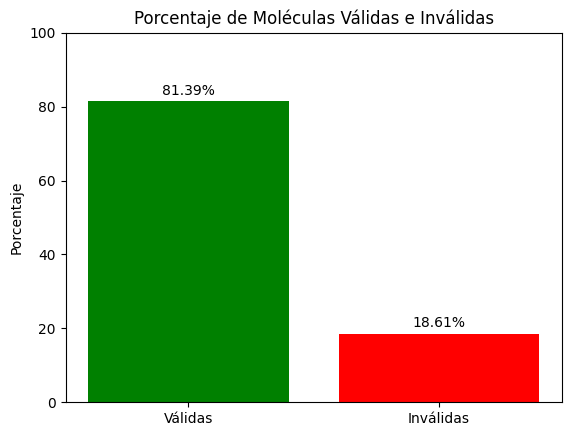

In [ ]:
# Crear la gráfica de barras
labels = ['Válidas', 'Inválidas']
percentages = [percentage_common, percentage_invalid]

fig, ax = plt.subplots()
bars = ax.bar(labels, percentages, color=['green', 'red'])

# Añadir las etiquetas de porcentaje encima de las barras
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.2f}%', ha='center', va='bottom')

# Añadir títulos y etiquetas
ax.set_ylabel('Porcentaje')
ax.set_title('Porcentaje de Moléculas Válidas e Inválidas')
plt.ylim(0, 100)

# Mostrar la gráfica
plt.show()

In [ ]:
# Filtrar el DataFrame para obtener los registros donde Predicted_pIC50 es mayor que Original_pIC50
filtered_df = merged_df_original_modified[merged_df_original_modified['Predicted_pIC50'] > merged_df_original_modified['Original_pIC50']]

# Mostrar el DataFrame resultante
filtered_df

,Modified_SMILES,Predicted_pIC50,Original_SMILES,molecule_chembl_id,class,Original_pIC50
0,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,9.595773,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CHEMBL2022564,active,9.494850
4,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,9.431921,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CHEMBL3234201,active,9.327902
5,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,9.420956,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CHEMBL3234201,active,9.327902
6,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,9.413009,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CHEMBL3234201,active,9.327902
7,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,9.402711,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CHEMBL3234201,active,9.327902
...,...,...,...,...,...,...
17211,N=C(N)NCCCC[C@H](N)C(=O)NCCCC[C@H](N)NCCCC(=O)...,4.241547,N=C(N)NCCCC[C@H](N)C(=O)NCCCC[C@H](N)C(=O)N[C@...,CHEMBL4554598,inactive,4.094204
17228,CCNCC(CC)C/C=C/c1nc(O)c2c(ccc3nc(Nc4c(Cl)cccc4...,4.202141,CCN(CC)C/C=C/c1nc(O)c2c(ccc3nc(Nc4c(Cl)cccc4Cl...,CHEMBL281957,inactive,4.000000
17229,CCCC(CC)C/C=C/c1nc(O)c2c(ccc3nc(Nc4c(Cl)cccc4C...,4.201691,CCN(CC)C/C=C/c1nc(O)c2c(ccc3nc(Nc4c(Cl)cccc4Cl...,CHEMBL281957,inactive,4.000000
17230,CCNC(CC)C/C=C/c1nc(O)c2c(ccc3nc(Nc4c(Cl)cccc4C...,4.197736,CCN(CC)C/C=C/c1nc(O)c2c(ccc3nc(Nc4c(Cl)cccc4Cl...,CHEMBL281957,inactive,4.000000


In [ ]:
# Por lo tanto el número de Predicted SMILES con predicted pIC50 mayor que el original son
print("Por lo tanto el número de Predicted SMILES con predicted pIC50 mayor que el original son: ", len(filtered_df))
print(f"\nDe las {len(merged_df_original_modified)} moléculas generadas")

Por lo tanto el número de Predicted SMILES con predicted pIC50 mayor que el original son:  8233

De las 17404 moléculas generadas


In [ ]:
# Definir el valor de epsilon
epsilon = 0.2

# Filtrar el DataFrame para obtener los registros donde la diferencia entre Predicted_pIC50 y Original_pIC50 sea menor o igual a epsilon
filtered_similar_df = filtered_df[
    (filtered_df['Predicted_pIC50'] - filtered_df['Original_pIC50']).abs() <= epsilon
]

# Mostrar el DataFrame resultante
filtered_similar_df

,Modified_SMILES,Predicted_pIC50,Original_SMILES,molecule_chembl_id,class,Original_pIC50
0,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,9.595773,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CHEMBL2022564,active,9.494850
4,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,9.431921,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CHEMBL3234201,active,9.327902
5,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,9.420956,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CHEMBL3234201,active,9.327902
6,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,9.413009,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CHEMBL3234201,active,9.327902
7,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,9.402711,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CHEMBL3234201,active,9.327902
...,...,...,...,...,...,...
17142,N=C(N)NCCN[C@H](NC(=O)c1sccc1NS(=O)(=O)c1ccc([...,4.397642,N=C(N)NCCC[C@H](NC(=O)c1sccc1NS(=O)(=O)c1ccc([...,CHEMBL1079279,inactive,4.283997
17143,N=C(N)NCCNCCCC[C@H](NC(=O)c1sccc1NS(=O)(=O)c1c...,4.396405,N=C(N)NCCC[C@H](NC(=O)c1sccc1NS(=O)(=O)c1ccc([...,CHEMBL1079279,inactive,4.283997
17211,N=C(N)NCCCC[C@H](N)C(=O)NCCCC[C@H](N)NCCCC(=O)...,4.241547,N=C(N)NCCCC[C@H](N)C(=O)NCCCC[C@H](N)C(=O)N[C@...,CHEMBL4554598,inactive,4.094204
17230,CCNC(CC)C/C=C/c1nc(O)c2c(ccc3nc(Nc4c(Cl)cccc4C...,4.197736,CCN(CC)C/C=C/c1nc(O)c2c(ccc3nc(Nc4c(Cl)cccc4Cl...,CHEMBL281957,inactive,4.000000


In [ ]:
# Mostrar el número de registros filtrados
print(f"Número de registros con Predicted_pIC50 similar a Original_pIC50 por diferencia de un epsilon de {epsilon}: {len(filtered_similar_df)}")

Número de registros con Predicted_pIC50 similar a Original_pIC50 por diferencia de un epsilon de 0.2: 697


In [ ]:
# Filtrar los registros donde Modified_SMILES es diferente de Original_SMILES
filtered_similar_df = filtered_similar_df[filtered_similar_df['Modified_SMILES'] != filtered_similar_df['Original_SMILES']]

# Eliminar duplicados basados en la columna Modified_SMILES
filtered_similar_df = filtered_similar_df.drop_duplicates(subset=['Modified_SMILES'])

# Resetear el índice del DataFrame
filtered_similar_df.reset_index(drop=True, inplace=True)

# Mostrar el DataFrame resultante
filtered_similar_df

,Modified_SMILES,Predicted_pIC50,Original_SMILES,molecule_chembl_id,class,Original_pIC50
0,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,9.595773,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CHEMBL2022564,active,9.494850
1,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,9.431921,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CHEMBL3234201,active,9.327902
2,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,9.420956,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CHEMBL3234201,active,9.327902
3,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,9.413009,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CHEMBL3234201,active,9.327902
4,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,9.402711,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CHEMBL3234201,active,9.327902
...,...,...,...,...,...,...
692,N=C(N)NCCN[C@H](NC(=O)c1sccc1NS(=O)(=O)c1ccc([...,4.397642,N=C(N)NCCC[C@H](NC(=O)c1sccc1NS(=O)(=O)c1ccc([...,CHEMBL1079279,inactive,4.283997
693,N=C(N)NCCNCCCC[C@H](NC(=O)c1sccc1NS(=O)(=O)c1c...,4.396405,N=C(N)NCCC[C@H](NC(=O)c1sccc1NS(=O)(=O)c1ccc([...,CHEMBL1079279,inactive,4.283997
694,N=C(N)NCCCC[C@H](N)C(=O)NCCCC[C@H](N)NCCCC(=O)...,4.241547,N=C(N)NCCCC[C@H](N)C(=O)NCCCC[C@H](N)C(=O)N[C@...,CHEMBL4554598,inactive,4.094204
695,CCNC(CC)C/C=C/c1nc(O)c2c(ccc3nc(Nc4c(Cl)cccc4C...,4.197736,CCN(CC)C/C=C/c1nc(O)c2c(ccc3nc(Nc4c(Cl)cccc4Cl...,CHEMBL281957,inactive,4.000000


In [ ]:
# Seleccionar las columnas específicas
columns_to_save = ['Modified_SMILES', 'Predicted_pIC50', 'molecule_chembl_id', 'class']
filtered_columns_df_to_save = filtered_similar_df[columns_to_save]

# Guardamos solo las nuevas moléculas cuyo valor predicho sea mayor que el original pIC50 despues de filtrar por epsilon y clase activa
filtered_columns_df_to_save.to_csv('/content/drive/My Drive/Colab Notebooks/data/bioactivity_data_new_molecules_after_filter.csv', index=False)

In [ ]:
filtered_columns_df_to_save

,Modified_SMILES,Predicted_pIC50,molecule_chembl_id,class
0,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,9.595773,CHEMBL2022564,active
1,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,9.431921,CHEMBL3234201,active
2,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,9.420956,CHEMBL3234201,active
3,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,9.413009,CHEMBL3234201,active
4,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,9.402711,CHEMBL3234201,active
...,...,...,...,...
692,N=C(N)NCCN[C@H](NC(=O)c1sccc1NS(=O)(=O)c1ccc([...,4.397642,CHEMBL1079279,inactive
693,N=C(N)NCCNCCCC[C@H](NC(=O)c1sccc1NS(=O)(=O)c1c...,4.396405,CHEMBL1079279,inactive
694,N=C(N)NCCCC[C@H](N)C(=O)NCCCC[C@H](N)NCCCC(=O)...,4.241547,CHEMBL4554598,inactive
695,CCNC(CC)C/C=C/c1nc(O)c2c(ccc3nc(Nc4c(Cl)cccc4C...,4.197736,CHEMBL281957,inactive


In [ ]:
# Función para obtener las diferencias entre dos strings
def get_differences(original, modified):
    diff = difflib.ndiff(original, modified)
    changes = [d for d in diff if d.startswith('- ') or d.startswith('+ ')]
    return changes

# Aplicar la función para obtener las diferencias y crear una nueva columna
filtered_similar_df['Differences'] = filtered_similar_df.apply(
    lambda row: get_differences(row['Original_SMILES'], row['Modified_SMILES']),
    axis=1
)

# Agregar una columna para el conteo de diferencias
filtered_similar_df['Num_Differences'] = filtered_similar_df['Differences'].apply(len)

# Mostrar el DataFrame resultante con las diferencias
filtered_similar_df[['Original_SMILES', 'Modified_SMILES', 'Differences', 'Num_Differences']]

,Original_SMILES,Modified_SMILES,Differences,Num_Differences
0,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,[+ O],1
1,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,[+ O],1
2,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,[- C],1
3,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,"[+ O, + C]",2
4,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,"[+ N, + C]",2
...,...,...,...,...
692,N=C(N)NCCC[C@H](NC(=O)c1sccc1NS(=O)(=O)c1ccc([...,N=C(N)NCCN[C@H](NC(=O)c1sccc1NS(=O)(=O)c1ccc([...,"[- C, + N]",2
693,N=C(N)NCCC[C@H](NC(=O)c1sccc1NS(=O)(=O)c1ccc([...,N=C(N)NCCNCCCC[C@H](NC(=O)c1sccc1NS(=O)(=O)c1c...,"[+ C, + C, + N, + C]",4
694,N=C(N)NCCCC[C@H](N)C(=O)NCCCC[C@H](N)C(=O)N[C@...,N=C(N)NCCCC[C@H](N)C(=O)NCCCC[C@H](N)NCCCC(=O)...,"[+ N, + C, + C, + C]",4
695,CCN(CC)C/C=C/c1nc(O)c2c(ccc3nc(Nc4c(Cl)cccc4Cl...,CCNC(CC)C/C=C/c1nc(O)c2c(ccc3nc(Nc4c(Cl)cccc4C...,[+ C],1


In [ ]:
# Encontrar la fila con el máximo número de diferencias
max_diff_row = filtered_similar_df['Num_Differences'].idxmax()

# Imprimir la fila con el máximo número de diferencias
print("Fila con el máximo número de diferencias:", max_diff_row)

Fila con el máximo número de diferencias: 387


In [ ]:
merged_df_original_modified.iloc[max_diff_row, :]

,387
Modified_SMILES,O=C(Nc1ccc(Cl)c(C(F)(F)F)c1)c1ccccc1Cn1cc:cccc...
Predicted_pIC50,8.211465
Original_SMILES,O=C(Nc1ccc(Cl)c(C(F)(F)F)c1)c1ccccc1Cn1ccc2cnc...
molecule_chembl_id,CHEMBL437889
class,active
Original_pIC50,6.387216


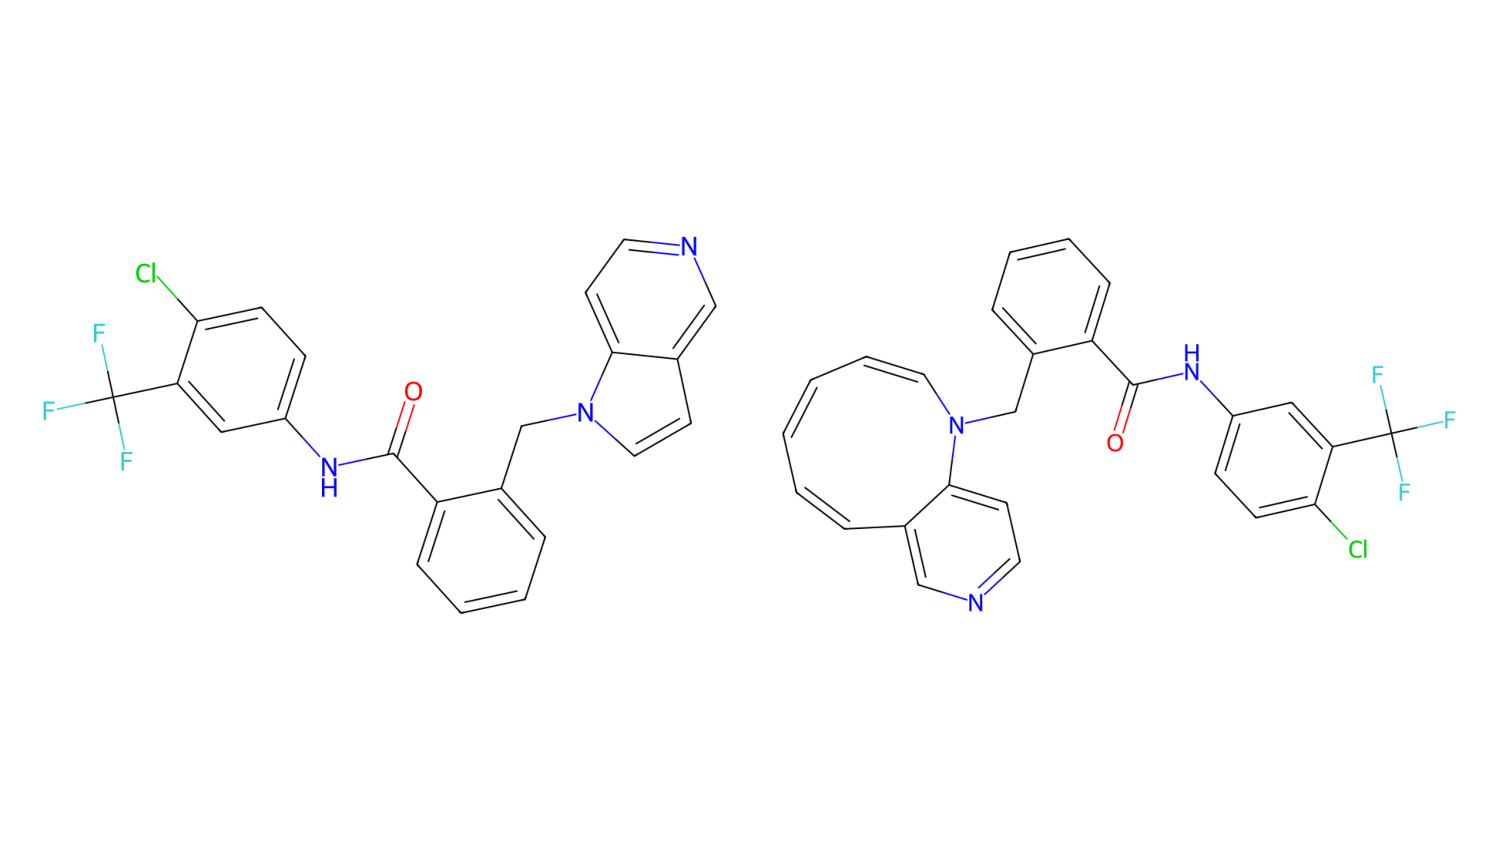

In [ ]:
# Función para visualizar moléculas lado a lado usando PIL y matplotlib en calidad Full HD
def visualize_molecules(df, index):
    original_smiles = df.loc[index, 'Original_SMILES']
    modified_smiles = df.loc[index, 'Modified_SMILES']

    original_mol = Chem.MolFromSmiles(original_smiles)
    modified_mol = Chem.MolFromSmiles(modified_smiles)

    original_img = Draw.MolToImage(original_mol, size=(960, 1080))
    modified_img = Draw.MolToImage(modified_mol, size=(960, 1080))

    # Crear una nueva imagen en blanco lo suficientemente grande para ambas moléculas
    combined_img = Image.new('RGB', (1920, 1080))
    combined_img.paste(original_img, (0, 0))
    combined_img.paste(modified_img, (960, 0))

    return combined_img

# Visualizar las moléculas de la primera fila
image = visualize_molecules(merged_df_original_modified, 387)

# Ajustar el tamaño de la figura
plt.figure(figsize=(19.2, 10.8))  # Ajusta el tamaño de la figura (ancho, alto) en pulgadas para mantener la relación 1920x1080

# Mostrar la imagen usando matplotlib
plt.imshow(image)
plt.axis('off')  # Ocultar los ejes
plt.show()

In [ ]:
# Crear un cliente para acceder a la API de ChEMBL
molecule = new_client.molecule

# Lista de ChEMBL IDs para los medicamentos de la familia del Omeprazol
chembl_ids = {
    "Omeprazole": "CHEMBL1503",
    "Pantoprazole": "CHEMBL1501",
    "Esomeprazole": "CHEMBL101527"
}

# Función para obtener SMILES de un ChEMBL ID
def get_smiles(chembl_id):
    try:
        res = molecule.get(chembl_id)
        return res['molecule_structures']['canonical_smiles']
    except:
        return 'Unknown'

# Obtener los SMILES para los medicamentos
smiles_dict = {name: get_smiles(chembl_id) for name, chembl_id in chembl_ids.items()}

# Mostrar los SMILES obtenidos
smiles_dict

{'Omeprazole': 'COc1ccc2[nH]c([S+]([O-])Cc3ncc(C)c(OC)c3C)nc2c1',
 'Pantoprazole': 'CC(=O)OCC(=O)[C@@]12OC(C)(C)O[C@@H]1C[C@H]1[C@@H]3C[C@H](F)C4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](O)C[C@@]12C',
 'Esomeprazole': 'Nc1nc(O)c2c(n1)NCC(COC(=O)c1ccc(C3(C(F)(F)F)N=N3)cc1)N2'}

In [ ]:
# Función para obtener las diferencias entre dos strings
def get_differences(original, modified):
    diff = difflib.ndiff(original, modified)
    changes = [d for d in diff if d.startswith('- ') or d.startswith('+ ')]
    return changes

# Comparar Omeprazole con otros medicamentos
omeprazole_smiles = smiles_dict["Omeprazole"]
data = []

for name, smiles in smiles_dict.items():
    if name != "Omeprazole":
        differences = get_differences(omeprazole_smiles, smiles)
        data.append({
            "Original_Name": "Omeprazole",
            "Original_SMILES": omeprazole_smiles,
            "Modified_Name": name,
            "Modified_SMILES": smiles,
            "Differences": differences
        })

# Crear el DataFrame
df_comparison = pd.DataFrame(data)

# Mostrar el DataFrame
df_comparison

,Original_Name,Original_SMILES,Modified_Name,Modified_SMILES,Differences
0,Omeprazole,COc1ccc2[nH]c([S+]([O-])Cc3ncc(C)c(OC)c3C)nc2c1,Pantoprazole,CC(=O)OCC(=O)[C@@]12OC(C)(C)O[C@@H]1C[C@H]1[C@...,"[+ C, + (, + =, - c, + ), + O, + C, + C, + (, ..."
1,Omeprazole,COc1ccc2[nH]c([S+]([O-])Cc3ncc(C)c(OC)c3C)nc2c1,Esomeprazole,Nc1nc(O)c2c(n1)NCC(COC(=O)c1ccc(C3(C(F)(F)F)N=...,"[+ N, + c, + 1, + n, + c, + (, + O, + ), + c, ..."


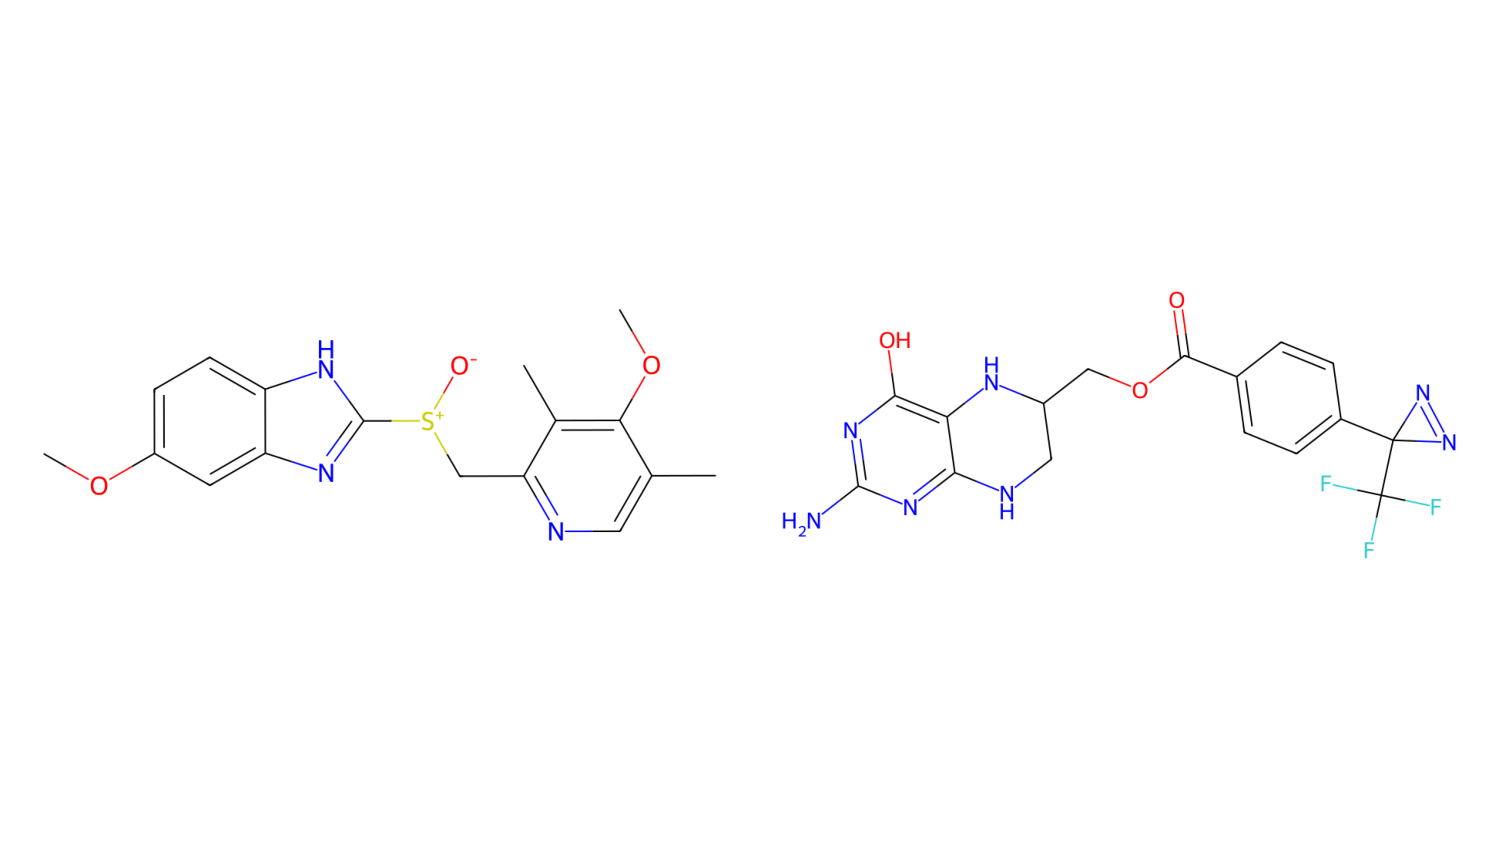

In [ ]:
# Visualizar las moléculas de la primera fila
image = visualize_molecules(df_comparison, 1)

# Ajustar el tamaño de la figura
plt.figure(figsize=(19.2, 10.8))  # Ajusta el tamaño de la figura (ancho, alto) en pulgadas para mantener la relación 1920x1080

# Mostrar la imagen usando matplotlib
plt.imshow(image)
plt.axis('off')  # Ocultar los ejes
plt.show()